<font size=7>Normalising Flow Experiment</font>

____

<font size=6>Some generative model theroy</font>

Change of Variable Theorem

Assume $x = T(z)$, where $T$ is a Transformation

According to probability $\int _{x}{P_x(X)dx} = \int _{z}{P_z(Z)dz}$

Therefore $|P_x(X)dx| = |P_z(Z)dz|$

$\qquad \qquad \quad \ \ P_x(X) = P_z(Z)|\frac{dz}{dx}|$

$\qquad \qquad \quad \ \ P_x(X) = P_z(Z)|\frac{\delta T^{-1}(x)}{\delta x}|$

$\qquad \qquad \quad \ \ P_x(X) = P_z(T^{-1}(x))|detJ_{T^{-1}}(x)|$

$\qquad \qquad \quad \ \ P_x(X) = P_z(Z)|detJ_{T}(Z)|^{-1}$

Likelihood Function for the Target Distribution

In normal flow parlance, $p_Z(z;\psi)$ is called the base distribution and $p_X(x)$ the target distribution. 
If $p_Z$ is a Gaussian, then $\psi = (\boldsymbol{\mu}, \boldsymbol{\Sigma})$

$T$ depends on parameters $\phi$. We can consider the likelihood of the data under the target distribution. Denoting the parameters by $\theta$, the likelihood is given by:

$P(\boldsymbol{X} \mid \theta) = \Pi^N_{i=1} P_x(\boldsymbol{x}_i \mid \theta)$

for $N$ data points $\boldsymbol{x}_i$, collectively denoted by $\boldsymbol{X}$.

For the log likelihood,

$ln P(X|\theta) = \displaystyle \sum^{N}_{i = 1}ln P_x(x_i|\theta)$ 

$\qquad \qquad \ \ = \displaystyle \sum^{N}_{i = 1} ln |detJ_T^{-1}(x_i;\phi)| + lnP_Z(T^{-1}(x_i;\phi);\psi)$

Typically, the base distribution is known and easy to sample from. Here, we take

$P_Z(z) = \mathcal{N}(\mu,\Sigma) = 2 \pi^{-D/2}|{det}(\Sigma)^{-\frac{1}{2}}| \exp \{-\frac{1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu)\}$

Calculating loss by KL divergence and log likelihood, where n real data we can sample from $P^{*}(X)$, $P_{x}(X;\theta)$ is a flow-based model.

$\mathcal{L}(\theta) = \mathcal{D}_{KL}[P^{*}(X)||P_{x}(X;\theta)]$

$\qquad \ =-E_{P^{*}(X)}[\log P_{x}(X;\theta)] + const$

$\qquad \ =-E_{P^{*}(X)}[\log P_{z}(T^{-1}(x;\theta)) + \log|det J_{T^{-1}}(x;\theta)|] + const$

$\qquad \ \approx -\frac{1}{N} \displaystyle \sum^{n}_{i = 1} [\log P_{z}(T^{-1}(x_i;\theta)) + \log|det J_{T^{-1}}(x_i;\theta)|] + const$

____

<font size=6>2D uniform transform</font>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as dist
import torch.utils.data as data
import torchvision

from torch import nn, optim
from numpy.random import default_rng

In [2]:
def draw_2D_graph(data,color="steelblue",size=5):
    fig = plt.figure(figsize = (3*6.4,1*6.4))
    ax = plt.subplot(1,3,1)
    plt.title("Total")
    ax = plt.scatter([i[0] for i in data],[i[1] for i in data],s=size,c=color)
    ax = plt.subplot(1,3,2)
    plt.title("X")
    ax = plt.hist([i[0] for i in data],20,density=True,color=color)
    ax = plt.subplot(1,3,3)
    plt.title("Y")
    ax = plt.hist([i[1] for i in data],20,density=True,color=color)

In [3]:
def compare_graph(data1,data2,title1,title2,color="steelblue",size=7):
    fig = plt.figure(figsize = (2*9.6,1*9.6))
    ax = plt.subplot(1,2,1)
    plt.title(title1)
    ax = plt.scatter(data1.T[0],data1.T[1],s=size,c=color)
    ax = plt.subplot(1,2,2)
    plt.title(title2)
    ax = plt.scatter(data2.T[0],data2.T[1],s=size,c=color)

In [4]:
def compare_3D_graph(data1,data2,title1,title2):
    fig = plt.figure(figsize=(2 * 9.6, 2 * 9.6))

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter3D(data1.T[0], data1.T[1], data1.T[2], c = np.abs(data1.T[0]) + np.abs(data1.T[1]) + np.abs(data1.T[2]), cmap =plt.get_cmap('rainbow_r'))
    plt.title(title1)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(data2.T[0], data2.T[1], data2.T[2], c = np.abs(data2.T[0]) + np.abs(data2.T[1]) + np.abs(data2.T[2]), cmap =plt.get_cmap('rainbow_r'))
    plt.title(title2)
    
    plt.show()

In [5]:
def compare_image(data1,data2,title1,title2):
    fig = plt.figure(figsize = (2*9.6,1*9.6))
    ax = plt.subplot(1,2,1)
    plt.title(title1)
    plt.imshow(np.transpose(data1.detach().numpy(),(1,2,0)),cmap = 'gray')
    ax = plt.subplot(1,2,2)
    plt.title(title2)
    plt.imshow(np.transpose(data2.detach().numpy(),(1,2,0)),cmap = 'gray')

In [6]:
def loss_graph(path,pos):
    data = torch.load(path)
    history = data["stats"]
    fig = plt.figure(figsize = (3*6.4,1*6.4))
    ax1 = plt.subplot()
    ax1.plot(history[0][:pos], 'r', label='Training Loss')
    ax1.plot(history[1][:pos], 'orange', label='Testing Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc='upper right')
    plt.title('Training and Testing loss')
    plt.show()

In [7]:
def validation(model,test_loader,loss_fn,target_distribution):
    epoch_loss = []
    with torch.no_grad():
        for x in test_loader:
            z, dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z,dz_by_dx)
            epoch_loss.append(loss)
    return np.mean(epoch_loss)

Generate uniform distrbution

In [486]:
rng = default_rng()

In [487]:
x_vals = rng.uniform(-1,1,1000)
y_vals = rng.uniform(-1,1,1000)

Combine two arrays and test

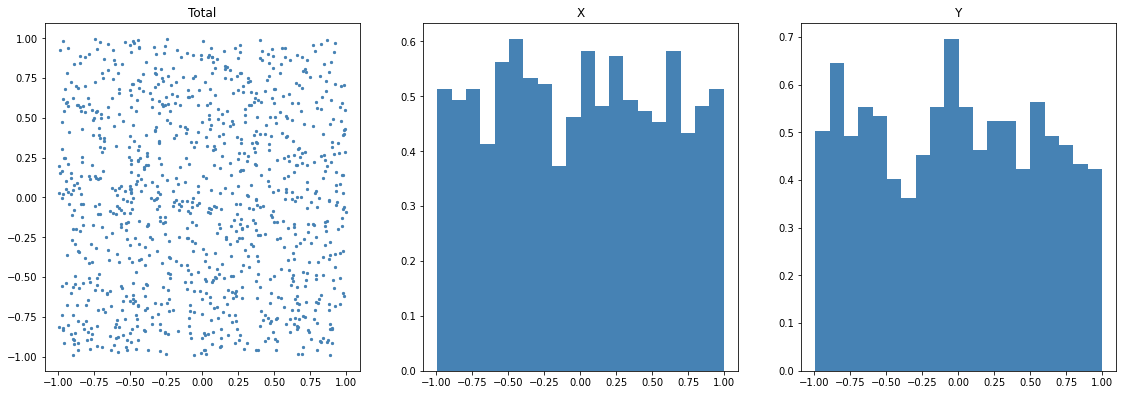

In [488]:
vals = []
for i in range(len(x_vals)):
    vals.append([x_vals[i],y_vals[i]])

draw_2D_graph(vals)

Change the weight to transform the uniform distrbution

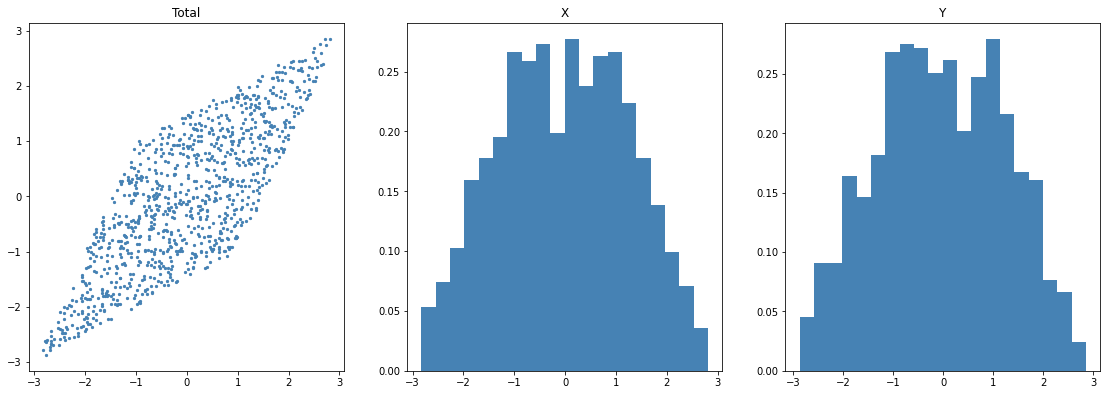

In [489]:
W = [[2,1],[1,2]]
trans_vals = np.dot(vals,W)

draw_2D_graph(trans_vals)

____

<font size=6>2D Guassain Transformation</font>

Generate 2D Guassain distribution

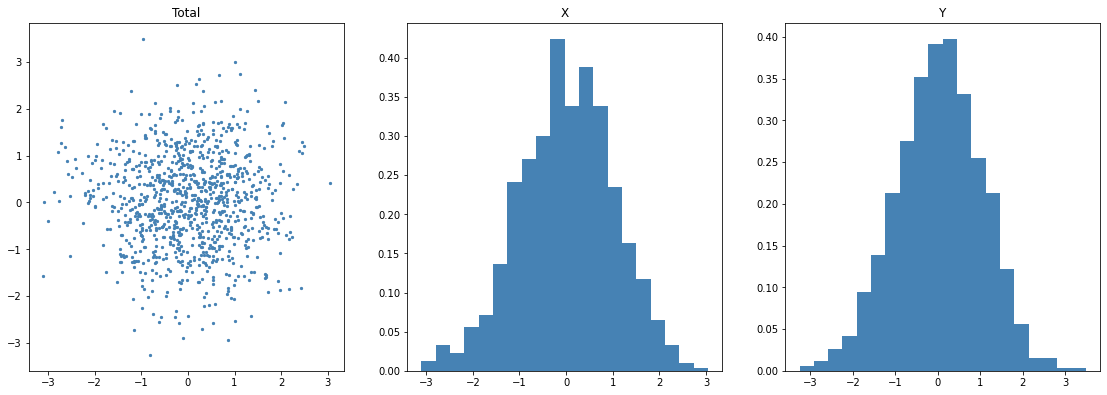

In [490]:
x_vals = rng.normal(0,1,1000)
y_vals = rng.normal(0,1,1000)

vals = []
for i in range(len(x_vals)):
    vals.append([x_vals[i],y_vals[i]])

draw_2D_graph(vals)

Set transform funtions, where $s(x)y = 5x^2y$ and $b(x) = 2x$, therefore $z = s(x)y + b(x)$

In [491]:
def transform (data):
    data_trans = []

    for data_point in data:
        data_y = 5 * data_point[0] * data_point[0] * data_point[1] + 2 * data_point[0]
        data_trans.append([data_point[0],data_y])

    return data_trans

Apply funtion and draw the output

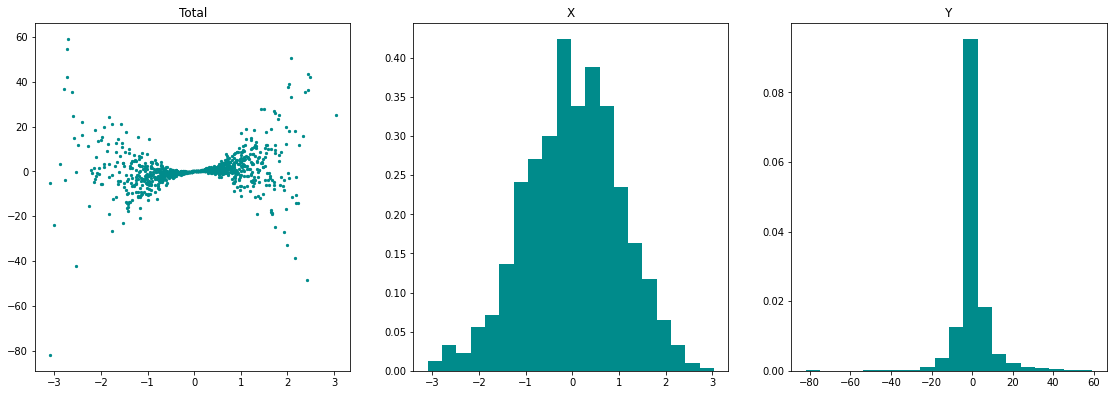

In [492]:
result = transform(vals)

draw_2D_graph(result,"darkcyan")

Set inverse transform funtions, where original $y = \frac{s(x)-2x}{5x^2}$

In [493]:
def inverse_transform (data):
    data_inverse_trans = []

    for data_point in data:
        data_y = (data_point[1] - 2 * data_point[0]) / (5 * data_point[0] * data_point[0])
        data_inverse_trans.append([data_point[0],data_y])

    return data_inverse_trans

Apply funtion and draw the output

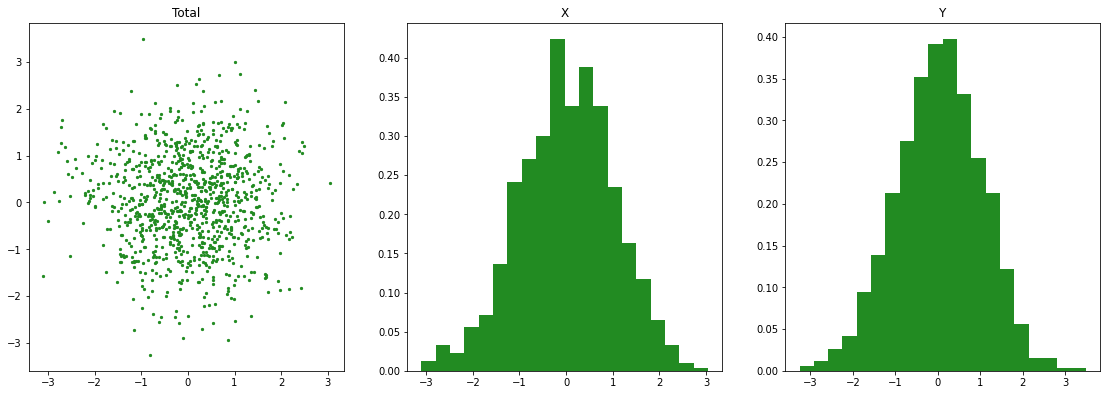

In [494]:
inverse_result = inverse_transform(result)

draw_2D_graph(inverse_result,"forestgreen")

____

<font size=6>SVD</font>

SVD ($A=UWV^T and\ A^{-1}=VW^{-1}U^T $), $A$ in SVD represent the model parameters

Set an original matrix $A$

In [495]:
m = np.mat("1,2;0,1")
m

matrix([[1, 2],
        [0, 1]])

Define $A^{-1}$ calculating function

In [496]:
def inverse_weight_matrix(m):
    u,sigma,vt = np.linalg.svd(m,full_matrices=True)

    s_inv = np.zeros([len(m),len(m)])
    for i in range(len(m)):
        s_inv[i][i] = 1/sigma[i]

    return np.dot(vt.T,s_inv).dot(u.T)

Calculate $A^{-1}$

In [497]:
np.around(inverse_weight_matrix(m))

matrix([[ 1., -2.],
        [ 0.,  1.]])

____

<font size=6>Implementation of SVD</font>

Generate the original data

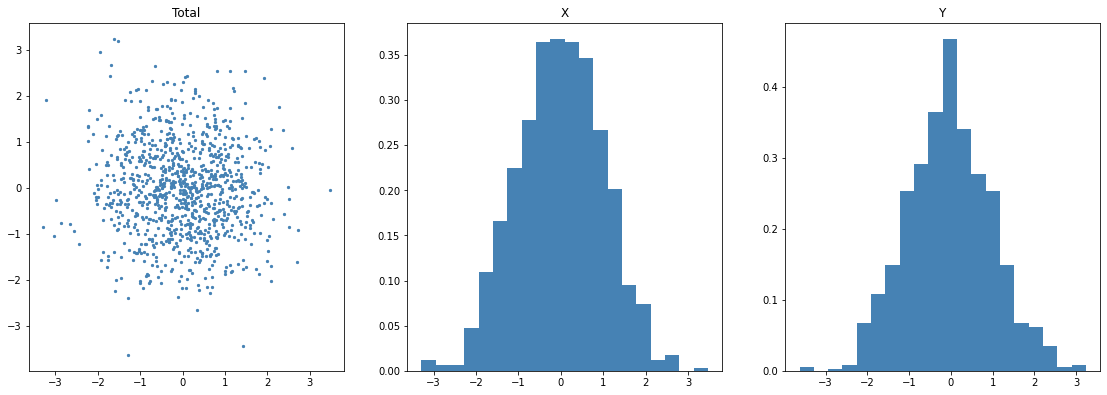

In [498]:
x_vals = rng.normal(0,1,1000)
y_vals = rng.normal(0,1,1000)

vals = []
for i in range(len(x_vals)):
    vals.append([x_vals[i],y_vals[i]])

draw_2D_graph(vals)

Define a funtion by matrix, i.e. $T(z) = 2x+3y$

In [499]:
W = [
    [1,0],
    [2,3]
]

W = np.array(W)

Calculating the transform result

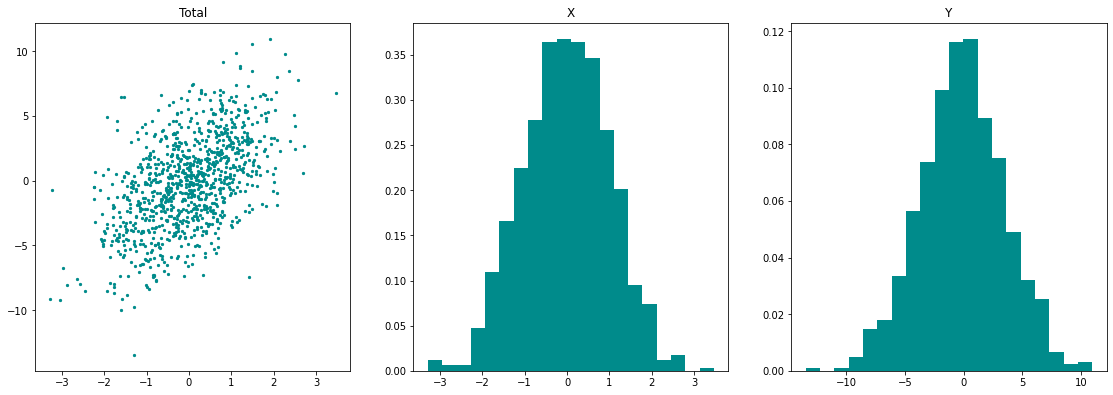

In [500]:
result = np.dot(vals,W.T)

draw_2D_graph(result,"darkcyan")

Inverse the Matrix to calculate orginal data

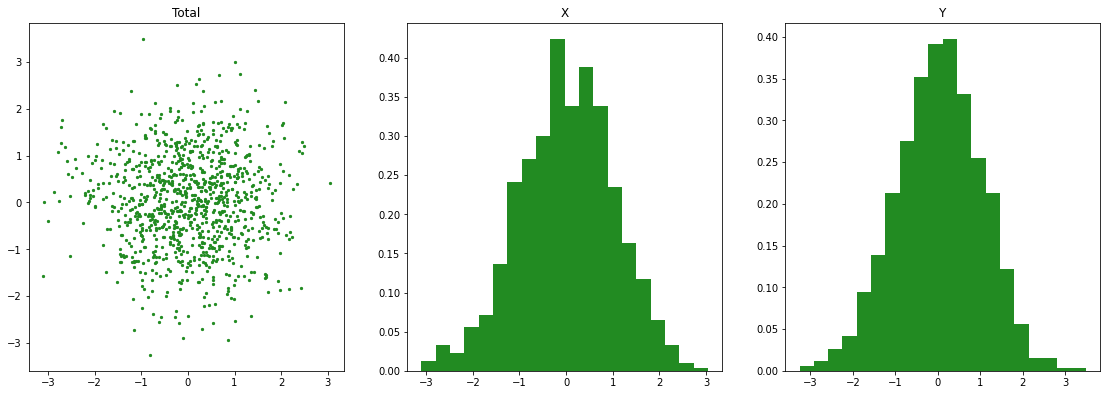

In [501]:
W_inv = inverse_weight_matrix(W.T)

draw_2D_graph(inverse_result,"forestgreen")

____

<font size=6>FCL transform pipline with KL Divergence</font>

Generate the original data (Uniform Distribution) / Convert original data to tensor and flatten it.

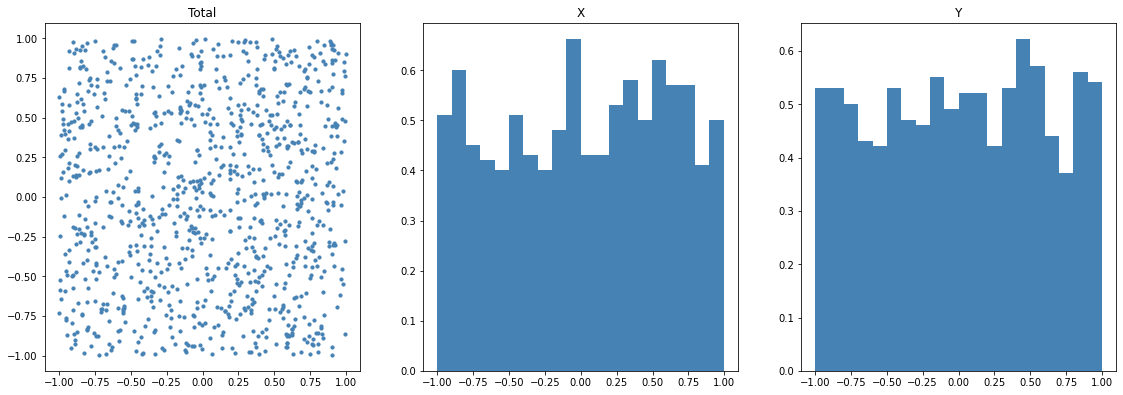

In [502]:
x_vals = rng.uniform(-1,1,1000)
y_vals = rng.uniform(-1,1,1000)

uniform = []
for i in range(len(x_vals)):
    uniform.append([x_vals[i],y_vals[i]])

draw_2D_graph(uniform,size=10)

input = torch.tensor(uniform) #input shape is (1000,2)
input = nn.Flatten(0,-1)(input) #input shape is (2000)

Convert target data to tensor and flatten it / Draw the target data.

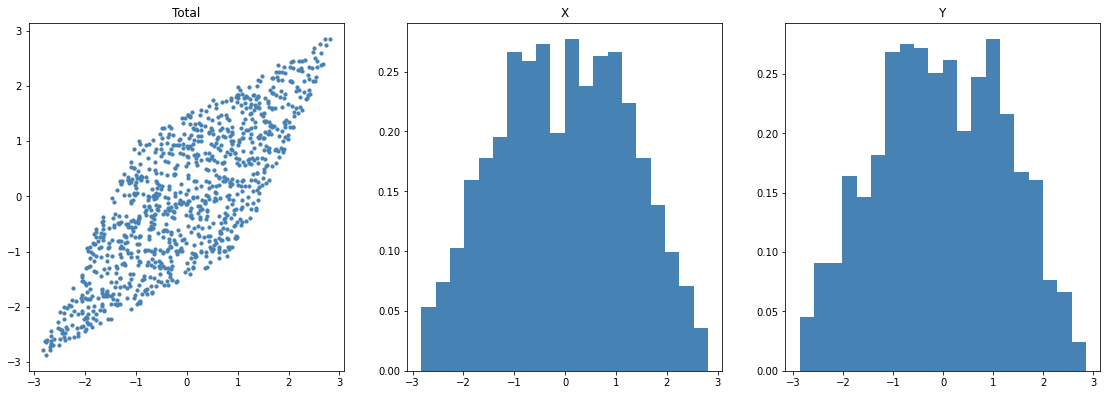

In [503]:
target = torch.tensor(trans_vals[:1000]) #target shape is (1000,2)
target = nn.Flatten(0,-1)(target) #target shape is (2000)

draw_2D_graph(trans_vals[:1000],size=10)

Define a very simple model with one layer

In [504]:
flow = nn.Sequential(
    nn.Linear(2000,2000),
)

Train the model, apply KL divergence to calculating loss 

In [505]:
loss_fn = nn.KLDivLoss(reduction='sum')
optimizer = optim.Adam(flow.parameters(), lr=0.001)

for epoch in range(50):

    optimizer.zero_grad()

    output = flow(input.float())
    loss = loss_fn(output.softmax(dim=-1).log(), target.float().softmax(dim=-1))
    loss.backward()

    optimizer.step()

    print(f"Iter:{epoch+1}   KLDivLoss:{loss.item(): .3f}")

Iter:1   KLDivLoss: 0.665
Iter:2   KLDivLoss: 0.203
Iter:3   KLDivLoss: 0.091
Iter:4   KLDivLoss: 0.150
Iter:5   KLDivLoss: 0.195
Iter:6   KLDivLoss: 0.171
Iter:7   KLDivLoss: 0.124
Iter:8   KLDivLoss: 0.104
Iter:9   KLDivLoss: 0.102
Iter:10   KLDivLoss: 0.103
Iter:11   KLDivLoss: 0.096
Iter:12   KLDivLoss: 0.082
Iter:13   KLDivLoss: 0.067
Iter:14   KLDivLoss: 0.057
Iter:15   KLDivLoss: 0.055
Iter:16   KLDivLoss: 0.053
Iter:17   KLDivLoss: 0.049
Iter:18   KLDivLoss: 0.043
Iter:19   KLDivLoss: 0.038
Iter:20   KLDivLoss: 0.034
Iter:21   KLDivLoss: 0.031
Iter:22   KLDivLoss: 0.027
Iter:23   KLDivLoss: 0.025
Iter:24   KLDivLoss: 0.023
Iter:25   KLDivLoss: 0.021
Iter:26   KLDivLoss: 0.018
Iter:27   KLDivLoss: 0.016
Iter:28   KLDivLoss: 0.014
Iter:29   KLDivLoss: 0.013
Iter:30   KLDivLoss: 0.013
Iter:31   KLDivLoss: 0.012
Iter:32   KLDivLoss: 0.010
Iter:33   KLDivLoss: 0.009
Iter:34   KLDivLoss: 0.008
Iter:35   KLDivLoss: 0.007
Iter:36   KLDivLoss: 0.006
Iter:37   KLDivLoss: 0.006
Iter:38   

Input the original data to genterate output from the model / Draw the predict output

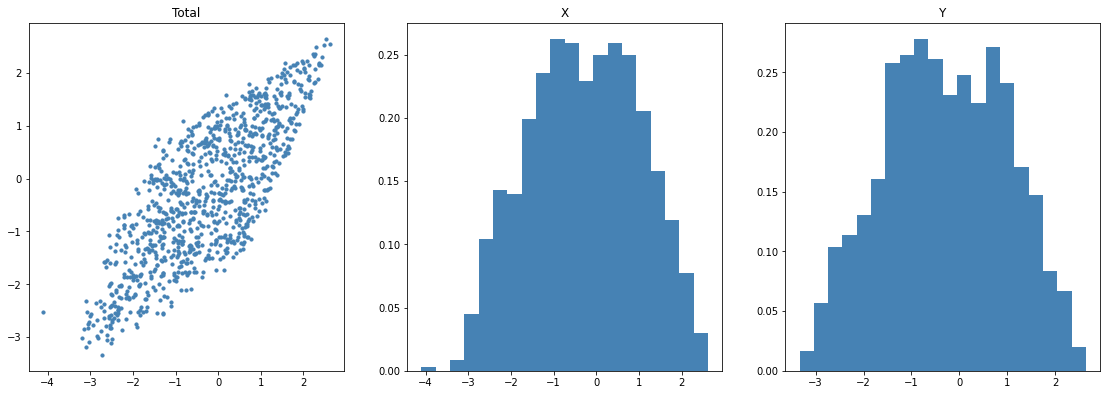

In [506]:
output = flow(input.float())

tmp_output = nn.Unflatten(0,(1000,2))(output)
tmp_output = tmp_output.detach().numpy()

draw_2D_graph(tmp_output,size=10)

Get parameters from the model, parameters are in matrix form.

In [507]:
parameter_matrix,bias = flow.parameters()

The output is actually calculated like $Input \cdot ParametersMatrix = Output $ i.e. $[1\times2000]\cdot[2000\times2000]=[1\times2000]$, the parameters matrix is $f$.

In [508]:
np.matmul(input,parameter_matrix.detach().numpy().T) + bias.detach().numpy()

tensor([-0.5940,  0.9814,  2.0268,  ..., -1.3257,  1.3632,  0.9691],
       dtype=torch.float64)

Applying SVD to get inverse parameters matrix, which is the $f^{-1}$.

In [510]:
inverse_matrix = inverse_weight_matrix(parameter_matrix.detach().numpy().T)

Apply output as input into $f^{-1}$ and try to get original data.

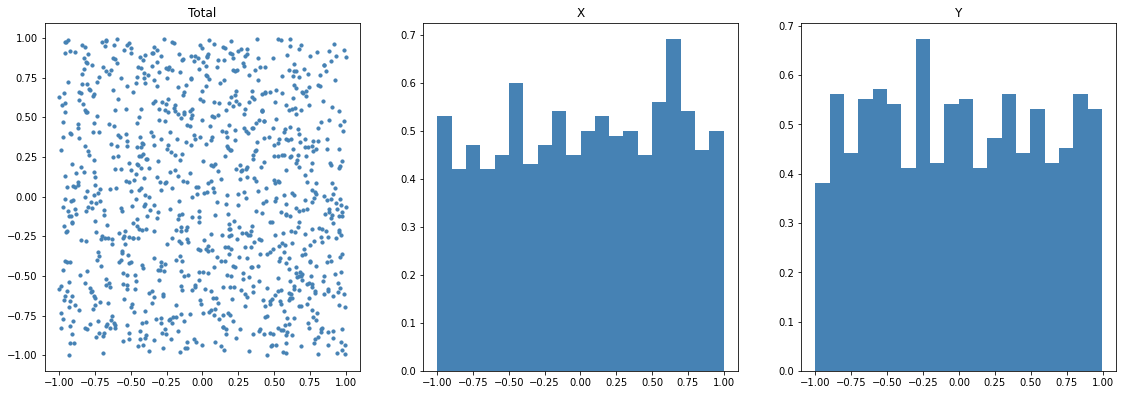

In [ ]:
tmp_input = np.matmul((output.detach().numpy() - bias.detach().numpy()),inverse_matrix)
predict_origin = torch.tensor(tmp_input).unflatten(0,(1000,2)).numpy()

draw_2D_graph(predict_origin,size=10)

____

<font size=6>Single transform pipline with log-likelihood 1-D</font>

Define a funtion to generate P(x) data

In [7]:
def mixture_guassian(number_of_points):
    n = number_of_points // 2
    guassain_1 = np.random.normal(loc=-1,scale=0.25,size=(n,))
    guassain_2 = np.random.normal(loc=0.5,scale=0.5,size=(number_of_points - n,))
    return np.concatenate([guassain_1,guassain_2])

Define a Dataset class

In [8]:
class Dataset(data.Dataset):

    def __init__(self,array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)

    def __getitem__(self,index):
        return self.array[index]

Define the model by using polynomial funtion $s(x) \times y+b(x)$ where $s(x)$ and $b(x)$ are 3rd polynomial

In [9]:
class flow_1d(nn.Module):

    def __init__(self,n_components):
        super(flow_1d,self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components),requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components),requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components),requires_grad=True)

    def forward(self,x):
        x = x.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1)
        distribution = torch.distributions.Normal(self.mus,self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1)
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        return z,dz_by_dx

Define loss funtion by negative log-likelihood

In [10]:
def loss_fn(target_distribution,z,dz_by_dx):
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()

Define the train funtion

In [18]:
def train(model,train_loader,test_loader,optimizer,target_distribution):
    epoch = 100
    history = np.zeros((2,epoch))
    model.train()
    for i in range(epoch):
        epoch_loss = []
        for x in train_loader:
            z, dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z,dz_by_dx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss)

        with torch.no_grad():
            train_loss = np.mean(epoch_loss)
            test_loss = validation(model,test_loader,loss_fn,target_distribution)
            print(f"Iter: {i+1} Train Loss: {train_loss: .3f} Test Loss: {test_loss: .3f}")

        history[:,i] = (train_loss,test_loss)

    torch.save({"stats": history}, '/Users/Siyuan/Documents/Learning/GitZone/MSc Project/1D Loss History')

Create dataset and dataloader

In [19]:
n_train, n_test = 2000, 2000
train_data = mixture_guassian(n_train)
test_data = mixture_guassian(n_test)

train_loader = data.DataLoader(Dataset(train_data),batch_size=128,shuffle=True)
test_loader = data.DataLoader(Dataset(test_data),batch_size=2000,shuffle=True)

Set target distribution which is Uniform

In [20]:
target_distribution = torch.distributions.Uniform(low=0,high=1)

Initiate the flow model and optimizer

In [21]:
flow = flow_1d(n_components=3)

optimizer = optim.Adam(flow.parameters(),lr=0.01)

Train the model

In [22]:
train(flow,train_loader,test_loader,optimizer,target_distribution)

Iter: 1 Train Loss:  1.339 Test Loss:  1.299
Iter: 2 Train Loss:  1.280 Test Loss:  1.261
Iter: 3 Train Loss:  1.257 Test Loss:  1.253
Iter: 4 Train Loss:  1.255 Test Loss:  1.251
Iter: 5 Train Loss:  1.252 Test Loss:  1.246
Iter: 6 Train Loss:  1.241 Test Loss:  1.230
Iter: 7 Train Loss:  1.211 Test Loss:  1.180
Iter: 8 Train Loss:  1.143 Test Loss:  1.099
Iter: 9 Train Loss:  1.066 Test Loss:  1.037
Iter: 10 Train Loss:  1.022 Test Loss:  1.015
Iter: 11 Train Loss:  1.013 Test Loss:  1.012
Iter: 12 Train Loss:  1.014 Test Loss:  1.011
Iter: 13 Train Loss:  1.013 Test Loss:  1.011
Iter: 14 Train Loss:  1.015 Test Loss:  1.010
Iter: 15 Train Loss:  1.011 Test Loss:  1.011
Iter: 16 Train Loss:  1.011 Test Loss:  1.010
Iter: 17 Train Loss:  1.013 Test Loss:  1.010
Iter: 18 Train Loss:  1.010 Test Loss:  1.010
Iter: 19 Train Loss:  1.014 Test Loss:  1.010
Iter: 20 Train Loss:  1.014 Test Loss:  1.011
Iter: 21 Train Loss:  1.013 Test Loss:  1.010
Iter: 22 Train Loss:  1.014 Test Loss:  1.0

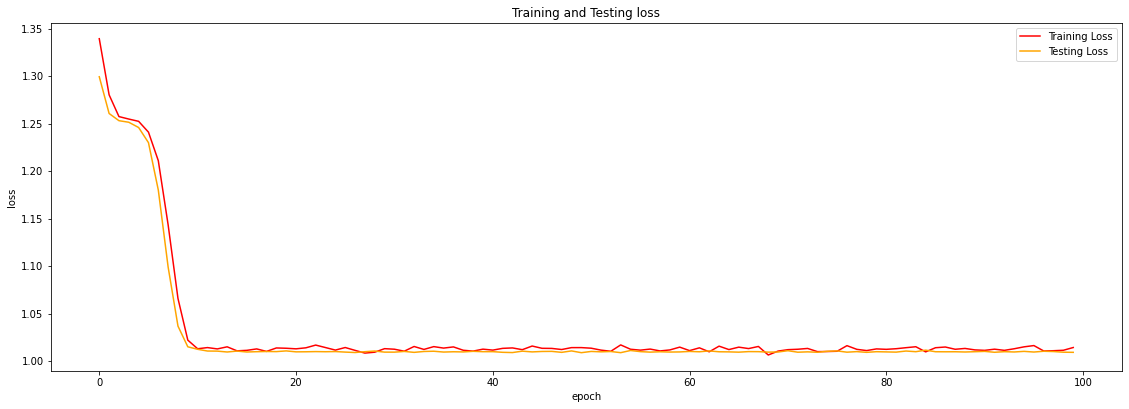

In [23]:
loss_graph('/Users/Siyuan/Documents/Learning/GitZone/MSc Project/1D Loss History',100)

Draw distribution of train data

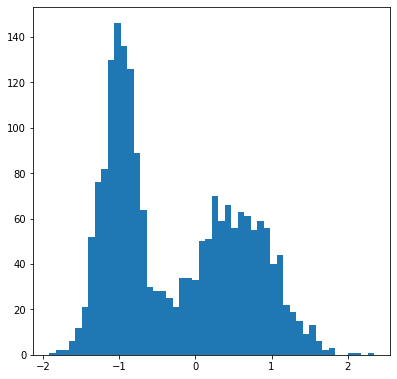

In [24]:
plt.figure(figsize = (1*6.4,1*6.4))
_ = plt.hist(train_data,bins=50)

Draw distribution of test data

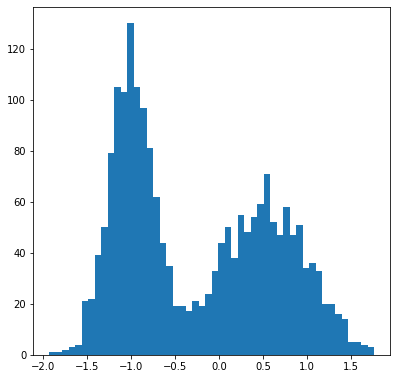

In [25]:
plt.figure(figsize = (1*6.4,1*6.4))
_ = plt.hist(test_data,bins=50)

Draw distribution of target (Uniform)

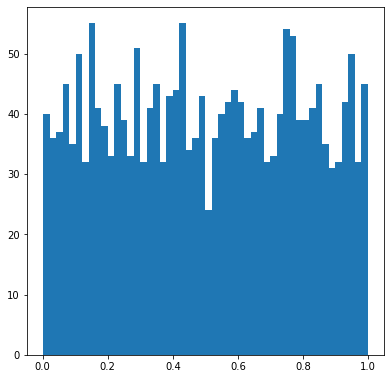

In [26]:
plt.figure(figsize = (1*6.4,1*6.4))
_ = plt.hist(target_distribution.sample([2000]).detach().numpy(),bins=50)

Draw $T(X)$ after training

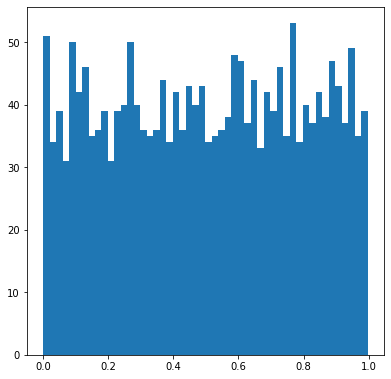

In [27]:
flow.eval()
z, dz_by_dx = flow(next(iter(test_loader)))

plt.figure(figsize = (1*6.4,1*6.4))
_ = plt.hist(z.detach().numpy(),bins=50)

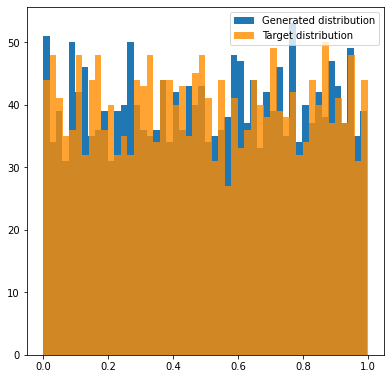

In [28]:
plt.figure(figsize = (1*6.4,1*6.4))
_ = plt.hist(z.detach().numpy(),bins=50,label='Generated distribution')
_ = plt.hist(target_distribution.sample([2000]).detach().numpy(),bins=50,color='darkorange',alpha=0.8,label='Target distribution')
_ = plt.legend(loc='upper right')

____

<font size=6>Single transform pipline with log-likelihood 2-D</font>

Define a funtion to generate P(x) data

In [ ]:
def mixture_guassian_2d(number_of_points):
    n = number_of_points // 2
    guassain_1 = np.random.multivariate_normal(mean=[-2.,2.],cov=[[2.,-1.],[-1.,2.]],size=(n))
    guassain_2 = np.random.multivariate_normal(mean=[2.,-2.],cov=[[4.,2.],[2.,4.]],size=(number_of_points - n))
    return np.concatenate([guassain_1,guassain_2])

Define a Dataset class

In [ ]:
class Dataset(data.Dataset):

    def __init__(self,array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)

    def __getitem__(self,index):
        return self.array[index]

Define the model by using polynomial funtion $s(x) \times y+b(x)$ where $s(x)$ and $b(x)$ are 3rd polynomial

In [ ]:
class flow_2d(nn.Module):

    def __init__(self,n_components):
        super(flow_2d,self).__init__()
        self.n_components = n_components
        self.phi = 0
        self.sweights = nn.Parameter(torch.randn(n_components,dtype=torch.double).view(-1,1),requires_grad=True)
        self.bweights = nn.Parameter(torch.randn(n_components,dtype=torch.double).view(-1,1),requires_grad=True)

    def forward(self,X):
        x = X.T[0].view(-1,1)
        y = X.T[1].view(-1,1)

        self.phi = x.T**0
        for i in range(self.n_components-1):
            self.phi = torch.vstack((self.phi,x.T**(i+1)))
        self.phi = self.phi.T

        s = torch.sigmoid(self.phi@self.sweights.view(-1,1))
        b = torch.sigmoid(self.phi@self.bweights.view(-1,1))
        y_new = s * y + b
        
        z = torch.vstack((x.T,y_new.T)).T

        return z,s

Define loss funtion by negative log-likelihood

In [ ]:
def loss_fn(target_distribution,z,log_dz_by_dx):
    log_likelihood = target_distribution.log_prob(z).view(-1,1) + log_dz_by_dx
    return -log_likelihood.mean()

Define the train funtion

In [ ]:
def train(model,epoch,train_loader,test_loader,optimizer,target_distribution):
    model.train()
    history = np.zeros((2,epoch))
    for i in range(epoch):
        epoch_loss = []
        for x in train_loader:
            z, dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z,dz_by_dx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss)

        with torch.no_grad():
            train_loss = np.mean(epoch_loss)
            test_loss = validation(model,test_loader,loss_fn,target_distribution)
            print(f"Iter: {i+1} Train Loss: {train_loss: .3f} Test Loss: {test_loss: .3f}")
        
        history[:,i] = (train_loss,test_loss)

    torch.save({"stats": history}, '/Users/Siyuan/Documents/Learning/GitZone/MSc Project/2D Loss History')

Create dataset and dataloader

In [ ]:
n_train, n_test = 2000, 2000
train_data = mixture_guassian_2d(n_train)
test_data = mixture_guassian_2d(n_test)

train_loader = data.DataLoader(Dataset(train_data),batch_size=256,shuffle=True)
test_loader = data.DataLoader(Dataset(test_data),batch_size=n_test,shuffle=True)

Initiate the flow model and optimizer

In [ ]:
flow = flow_2d(3)
optimizer = optim.Adam(flow.parameters(),lr=0.001)

Set the target distribution which is Multivariate Normal

In [ ]:
target_distribution = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Compare $P(X)$ and before trained $T(X)$

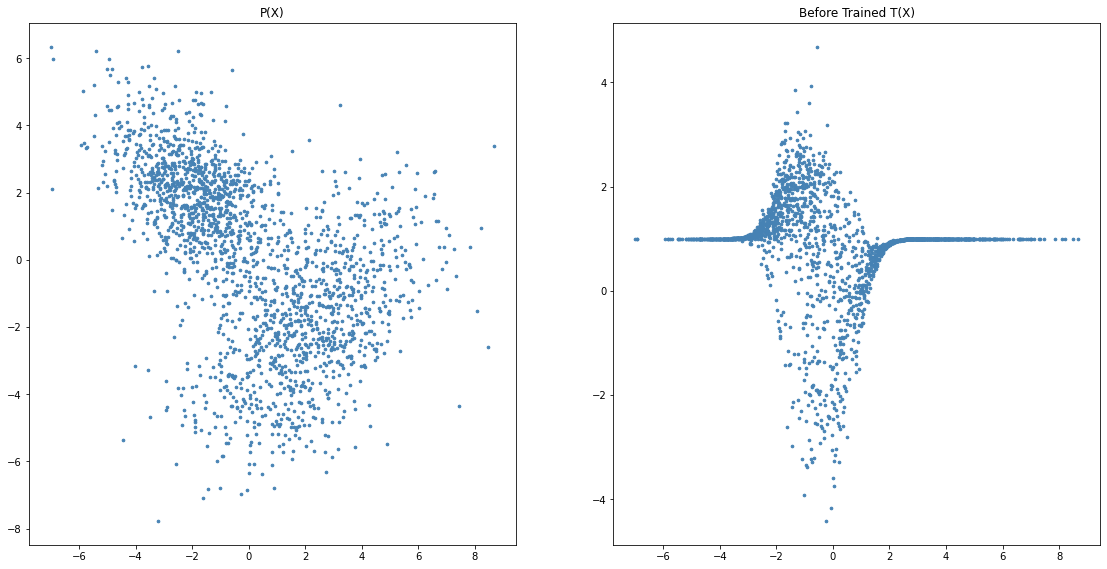

In [ ]:
before_train = next(iter(test_loader))
flow.eval()
z,dz_by_dx = flow(before_train)

compare_graph(test_data,z.detach().numpy(),"P(X)","Before Trained T(X)")

In [ ]:
train(flow,1000,train_loader,optimizer,target_distribution)

Iter: 1 Loss: 7.3930233588121546
Iter: 2 Loss: 7.371088638301929
Iter: 3 Loss: 7.360602223582905
Iter: 4 Loss: 7.358392712130911
Iter: 5 Loss: 7.347375990416835
Iter: 6 Loss: 7.34612176585593
Iter: 7 Loss: 7.314612771019036
Iter: 8 Loss: 7.319981793262151
Iter: 9 Loss: 7.306602260591115
Iter: 10 Loss: 7.277921169618787
Iter: 11 Loss: 7.2633540302705395
Iter: 12 Loss: 7.242805959707587
Iter: 13 Loss: 7.231542619272776
Iter: 14 Loss: 7.212125636592983
Iter: 15 Loss: 7.172448469791975
Iter: 16 Loss: 7.153029260306427
Iter: 17 Loss: 7.105449884263593
Iter: 18 Loss: 7.084745291572298
Iter: 19 Loss: 7.03796443228696
Iter: 20 Loss: 7.00694980376978
Iter: 21 Loss: 6.939834540563325
Iter: 22 Loss: 6.910292325801279
Iter: 23 Loss: 6.826442210097714
Iter: 24 Loss: 6.7347267571733855
Iter: 25 Loss: 6.635391214265873
Iter: 26 Loss: 6.529322559836299
Iter: 27 Loss: 6.393264037475948
Iter: 28 Loss: 6.2825611071992675
Iter: 29 Loss: 6.166103498946298
Iter: 30 Loss: 6.102631659573852
Iter: 31 Loss: 6.0

Compare target distribution and after trained $T(X)$

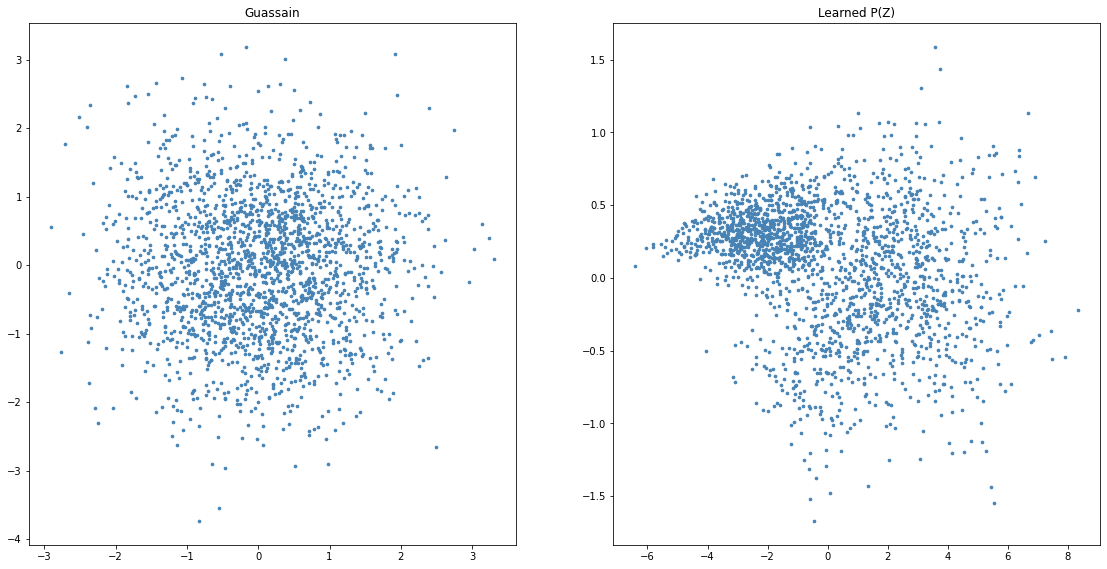

In [ ]:
after_train = next(iter(test_loader))
flow.eval()
z,dz_by_dx = flow(after_train)

compare_graph(target_distribution.sample([2000]).detach().numpy(),z.detach().numpy(),"Guassain","Trained T(X)")

Compare $P(X)$ and after trained $T(X)$

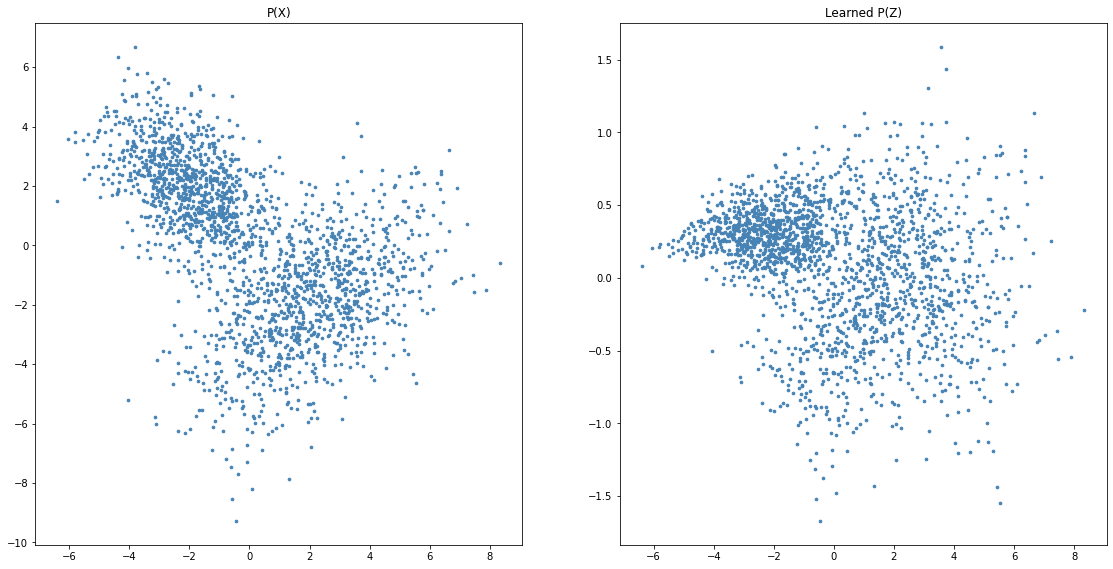

In [ ]:
compare_graph(test_data,z.detach().numpy(),"P(X)","Learned P(Z)")

____

<font size=6>Normalising flow pipline with NLL 2-D</font>

Define a funtion to generate P(x) data

In [29]:
def mixture_guassian_2d(number_of_points):
    n = number_of_points // 3
    guassain_1 = np.random.multivariate_normal(mean=[-2.,4.],cov=[[4.,-2.],[-2.,4.]],size=(n))
    guassain_2 = np.random.multivariate_normal(mean=[-1.,0.],cov=[[1.,0.],[0.,4.]],size=(n))
    guassain_3 = np.random.multivariate_normal(mean=[2.,2.],cov=[[4.,2.],[2.,4.]],size=(number_of_points - 2 * n))
    return np.concatenate([guassain_1,guassain_2,guassain_3])

Define a Dataset class

In [30]:
class Dataset(data.Dataset):

    def __init__(self,array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)

    def __getitem__(self,index):
        return self.array[index]

Define the model by applying Real NVP method

In [272]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_size, hidden_size, dtype=torch.double)]
        for _ in range(num_hidden_layers - 1):
            layers.append( nn.Linear(hidden_size, hidden_size, dtype=torch.double) )
            layers.append( nn.ReLU() )
        layers.append( nn.Linear(hidden_size, output_size, dtype=torch.double) )
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class flow_2d(nn.Module):
    def __init__(self, pos, hidden_size=64, num_hidden_layers=2):
        super(flow_2d, self).__init__()
        self.mlp = MLP(2, hidden_size, num_hidden_layers, 2)
        if pos == 1: 
            self.mask = torch.tensor([1,0],dtype=torch.double) 
        else:
            self.mask = torch.tensor([0,1],dtype=torch.double)
        self.mask = self.mask.view(1,-1)
        self.scale_weight = nn.Parameter(torch.zeros(1,dtype=torch.double), requires_grad=True)
        self.bias_weight = nn.Parameter(torch.zeros(1,dtype=torch.double), requires_grad=True)

    def forward(self, x, reverse=False):
        x_masked = x * self.mask
        log_scale, bias = self.mlp(x_masked).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_weight + self.bias_weight
        bias = bias  * (1-self.mask)
        log_scale = log_scale * (1-self.mask)
        if reverse:
            x = (x - bias) * torch.exp(-log_scale)
        else:
            x = x * torch.exp(log_scale) + bias
        return x, log_scale

Define a model to compose flows and pass results

In [273]:
class compose_flow(nn.Module):
    def __init__(self, flow_list):
        super(compose_flow, self).__init__()
        self.flow_list = nn.ModuleList(flow_list)

    def forward(self, x):
        z, log_det_jacobian = x, torch.zeros_like(x)
        for flow in self.flow_list:
            z, log_scale = flow(z)
            log_det_jacobian += log_scale
        return z, log_det_jacobian

    def inverse(self, z):
        list = []
        for flow in self.flow_list[::-1]:
            z, _ = flow(z, reverse=True)
            list.append(z)
        return list

Define loss funtion by negative log-likelihood

In [33]:
def loss_fn(target_distribution,z,sum_log_dz_by_dx):
    log_likelihood = target_distribution.log_prob(z).view(-1,1) + sum_log_dz_by_dx
    return -log_likelihood.mean()

Define the train funtion

In [274]:
def train(model,epoch,train_loader,test_loader,target_distribution,lr=0.001):
    optimizer = optim.AdamW(flows.parameters(),lr=lr)
    model.train()
    history = np.zeros((2,epoch))
    for i in range(epoch):
        epoch_loss = []
        for x in train_loader:
            z, sum_log_dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z,sum_log_dz_by_dx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss)

        with torch.no_grad():
            train_loss = np.mean(epoch_loss)
            test_loss = validation(model,test_loader,loss_fn,target_distribution)
            if (i + 1) % 100 == 0:
                print(f"Iter: {i+1} Train Loss: {train_loss: .3f} Test Loss: {test_loss: .3f}")
        history[:,i] = (train_loss,test_loss)

    torch.save({"stats": history}, '/Users/Siyuan/Documents/Learning/GitZone/MSc Project/2D Loss History')

Create dataset and dataloader

In [275]:
train_data = mixture_guassian_2d(1024)
test_data = mixture_guassian_2d(1024)

train_loader = data.DataLoader(Dataset(train_data),batch_size=512,shuffle=True)
test_loader = data.DataLoader(Dataset(test_data),batch_size=1024,shuffle=True)

Initiate the flow model and optimizer

In [276]:
flows_list = [flow_2d(1), flow_2d(2),flow_2d(1), flow_2d(2),flow_2d(1), flow_2d(2)]
flows = compose_flow(flows_list)

Set the target distribution which is Multivariate Normal

In [89]:
target_distribution = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Compare $P(X)$ and before trained $T(X)$

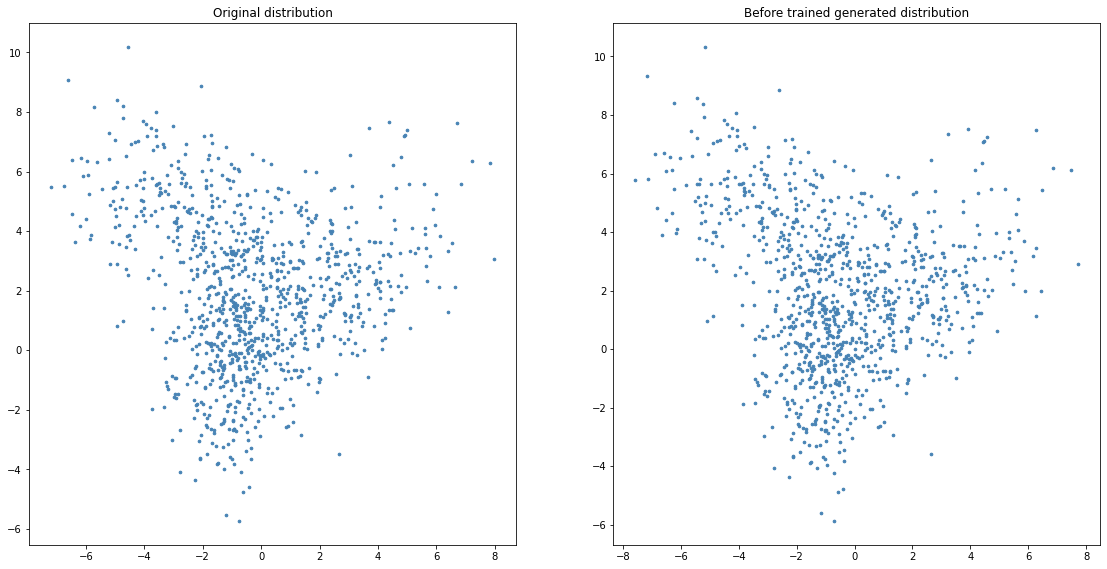

In [277]:
before_train = next(iter(test_loader))
flows.eval()
z,dz_by_dx = flows(before_train)

compare_graph(test_data,z.detach().numpy(),"Original distribution","Before trained generated distribution")

Train the flows

In [278]:
train(flows,2000,train_loader,test_loader,target_distribution,lr=0.001)

Iter: 100 Train Loss:  3.649 Test Loss:  3.731
Iter: 200 Train Loss:  3.495 Test Loss:  3.553
Iter: 300 Train Loss:  3.481 Test Loss:  3.539
Iter: 400 Train Loss:  3.476 Test Loss:  3.538
Iter: 500 Train Loss:  3.473 Test Loss:  3.540
Iter: 600 Train Loss:  3.473 Test Loss:  3.547
Iter: 700 Train Loss:  3.468 Test Loss:  3.552
Iter: 800 Train Loss:  3.472 Test Loss:  3.553
Iter: 900 Train Loss:  3.464 Test Loss:  3.548
Iter: 1000 Train Loss:  3.471 Test Loss:  3.550
Iter: 1100 Train Loss:  3.457 Test Loss:  3.562
Iter: 1200 Train Loss:  3.455 Test Loss:  3.560
Iter: 1300 Train Loss:  3.455 Test Loss:  3.586
Iter: 1400 Train Loss:  3.445 Test Loss:  3.572
Iter: 1500 Train Loss:  3.438 Test Loss:  3.579
Iter: 1600 Train Loss:  3.442 Test Loss:  3.581
Iter: 1700 Train Loss:  3.444 Test Loss:  3.583
Iter: 1800 Train Loss:  3.451 Test Loss:  3.578
Iter: 1900 Train Loss:  3.437 Test Loss:  3.602
Iter: 2000 Train Loss:  3.438 Test Loss:  3.598


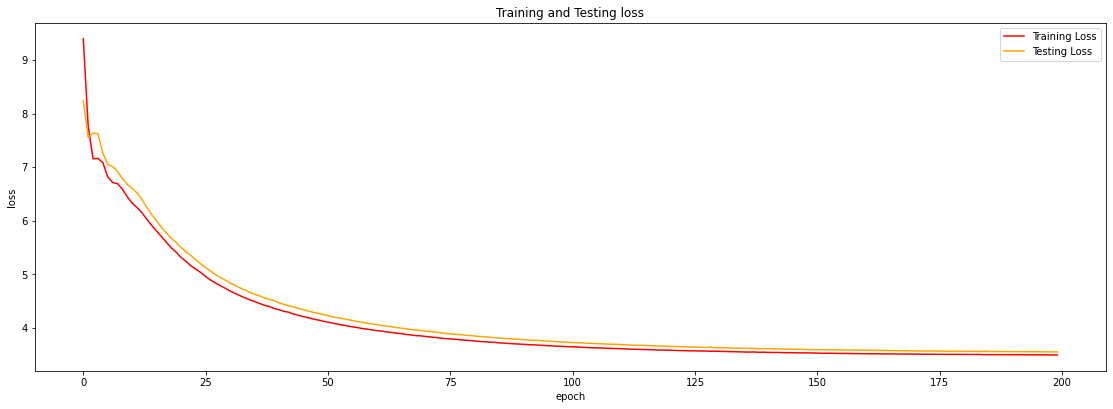

In [288]:
loss_graph('/Users/Siyuan/Documents/Learning/GitZone/MSc Project/2D Loss History',200)

Compare target distribution and after trained $T(X)$

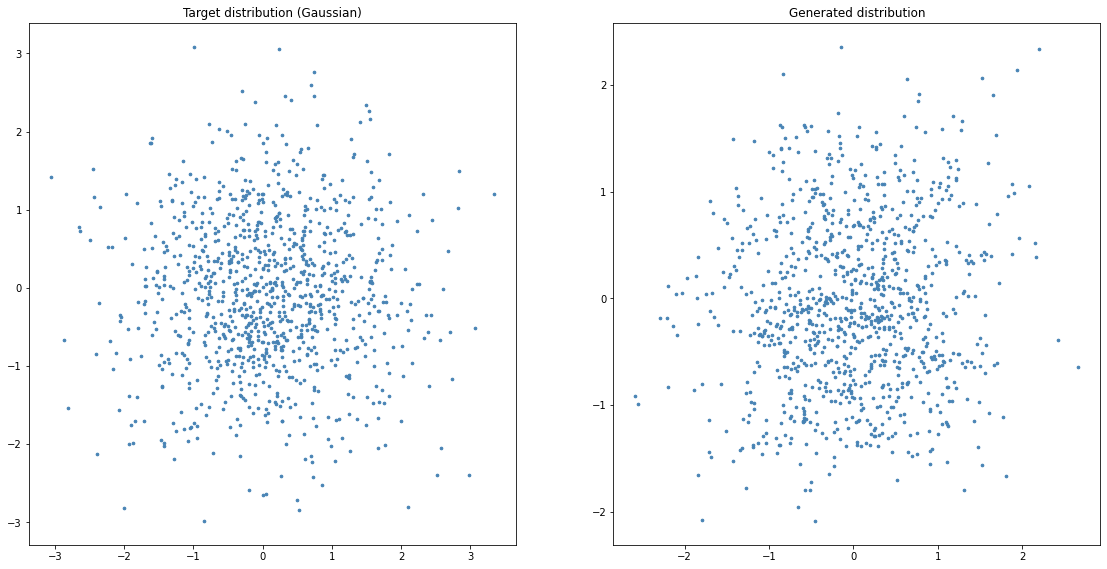

In [289]:
after_train = next(iter(test_loader))
flows.eval()
z,dz_by_dx = flows(after_train)

compare_graph(target_distribution.sample([1024]).detach().numpy(),z.detach().numpy(),"Target distribution (Gaussian)","Generated distribution")

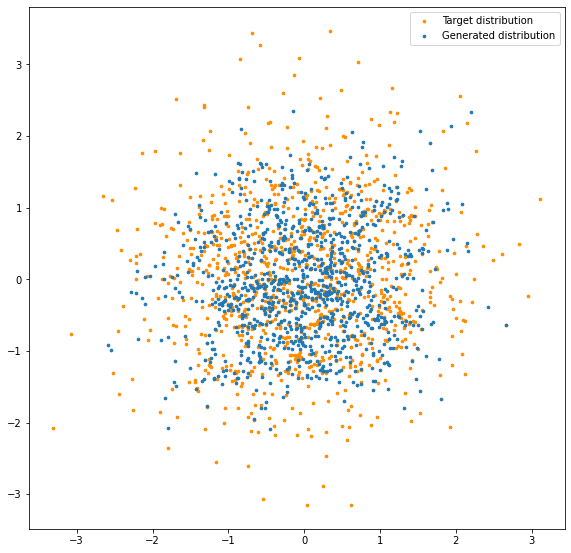

In [290]:
t = target_distribution.sample([1024]).detach().numpy()
g = z.detach().numpy()

plt.figure(figsize = (1*9.6,1*9.6))
_ = plt.scatter(t.T[0],t.T[1],s=7,c="darkorange",label='Target distribution')
_ = plt.scatter(g.T[0],g.T[1],s=7,label='Generated distribution')
_ = plt.legend(loc='upper right')

Compare $P(X)$ and after trained $T(X)$

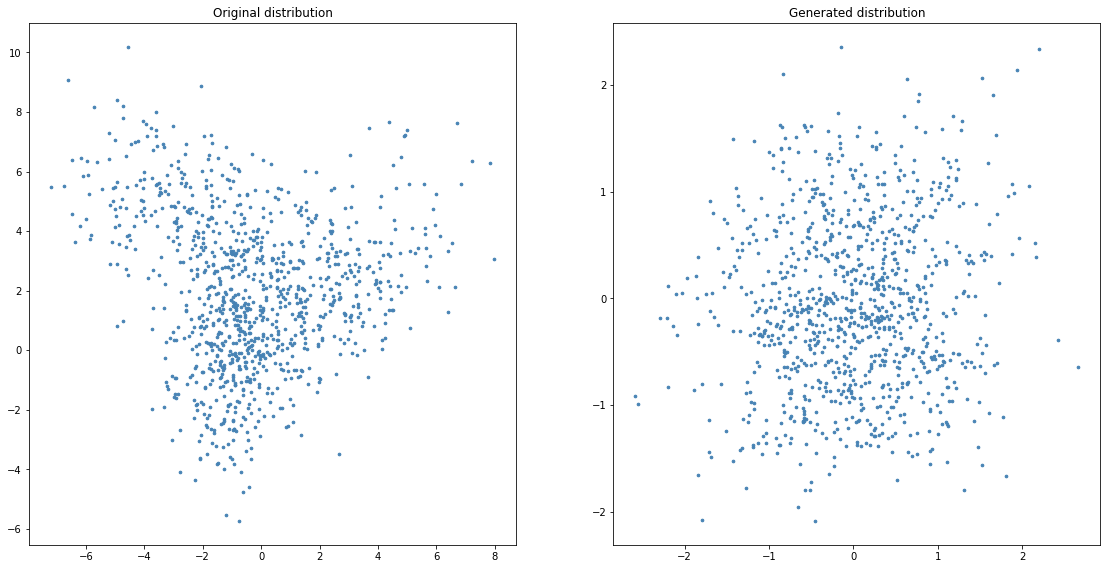

In [291]:
compare_graph(test_data,z.detach().numpy(),"Original distribution","Generated distribution")

Draw a graph of every inverse state

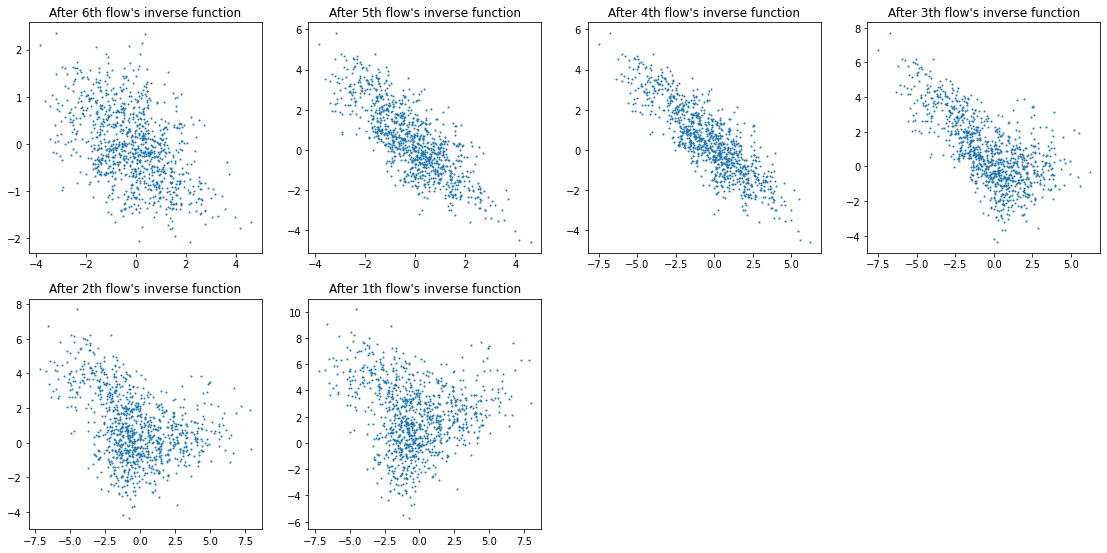

In [292]:
ls = flows.inverse(z)
fig = plt.figure(figsize = (4*4.8,3*4.8))
generated_from_trainning_result = 0

for f in range(len(ls)):
    ax = plt.subplot(3,4,f+1)
    plt.title("After {}th flow's inverse function".format(len(ls) - f))

    z_ = ls[f].detach().numpy()
    generated_from_trainning_result = z_
    x, y = z_.T[0], z_.T[1]
    ax = plt.scatter(x,y,s=1)

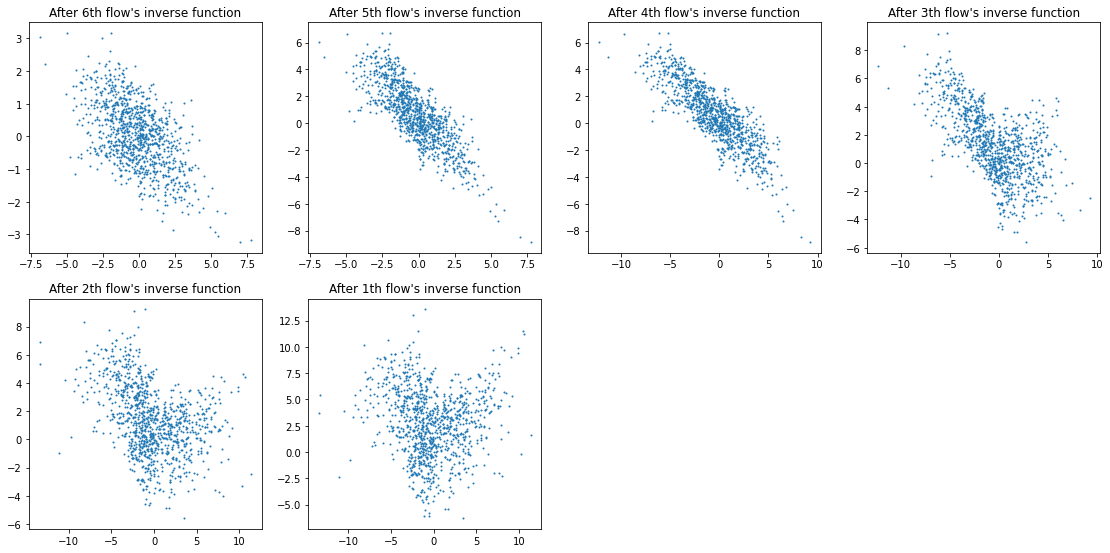

In [293]:
g = target_distribution.sample([1024])
ls = flows.inverse(g)
fig = plt.figure(figsize = (4*4.8,3*4.8))
generated_from_gaussian = 0

for f in range(len(ls)):
    ax = plt.subplot(3,4,f+1)
    plt.title("After {}th flow's inverse function".format(len(ls) - f))

    z_ = ls[f].detach().numpy()
    generated_from_gaussian = z_
    x, y = z_.T[0], z_.T[1]
    ax = plt.scatter(x,y,s=1)

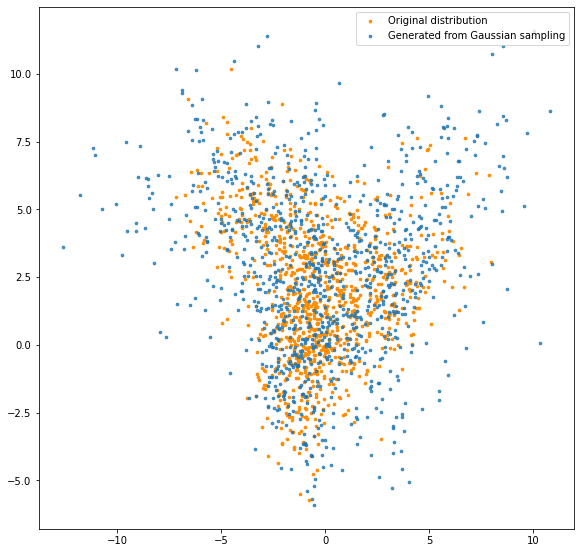

In [285]:
t = generated_from_trainning_result
g = generated_from_gaussian

plt.figure(figsize = (1*9.6,1*9.6))
_ = plt.scatter(t.T[0],t.T[1],s=7,c="darkorange",label='Original distribution')
_ = plt.scatter(g.T[0],g.T[1],s=7,alpha=0.8,label='Generated from Gaussian sampling')
_ = plt.legend(loc='upper right')

____

<font size=6>Normalising flow pipline of dataset with multiple probability distributions NLL 2-D</font>

Generate P(x) data

In [ ]:
Beta = torch.distributions.Beta(torch.tensor([1.,1.]),torch.tensor([1.,1.]))
w1 = [[1.,2.],[2.,1.]]
w2 = [[1.,2.],[2.,1.]]
w3 = [[1.,2.],[-2.,1.]]

dist1 = (Beta.sample([1000])@torch.tensor(w1)).detach().numpy()
dist2 = (Beta.sample([1000])@torch.tensor(w2)@torch.tensor(w3)).detach().numpy()
dist3 = (Beta.sample([1000])@torch.tensor(w1)).detach().numpy()
dist4 = (Beta.sample([1000])@torch.tensor(w2)@torch.tensor(w3)).detach().numpy()

dist1, dist2, dist3, dist4 = np.double(dist1), np.double(dist2), np.double(dist3), np.double(dist4)

train_dist, test_dist = np.concatenate([dist1,dist2]), np.concatenate([dist3,dist4])

draw_2D_graph(train_dist)

Define a Dataset class

In [ ]:
class Dataset(data.Dataset):

    def __init__(self,array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)

    def __getitem__(self,index):
        return self.array[index]

Define the model by using polynomial funtion $s(x) \times y+b(x)$ where $s(x)$ and $b(x)$ are 3rd polynomial and its inverse funtion

In [ ]:
class flow_2d(nn.Module):

    def __init__(self,n_components,flows_number=1):
        super(flow_2d,self).__init__()
        self.n_components = n_components
        self.flows_number = flows_number
        self.phi = 0
        self.sweights = nn.Parameter(torch.randn(n_components,dtype=torch.double).view(-1,1),requires_grad=True)
        self.bweights = nn.Parameter(torch.randn(n_components,dtype=torch.double).view(-1,1),requires_grad=True)
        self.w1_weights = nn.Parameter(torch.tensor(1,dtype=torch.double).view(-1,1),requires_grad=True)
        self.w2_weights = nn.Parameter(torch.tensor(1,dtype=torch.double).view(-1,1),requires_grad=True)


    def forward(self,X):
        if self.flows_number % 2 == 1:
            x = X.T[0].view(-1,1)
            y = X.T[1].view(-1,1)
        else:
            x = X.T[1].view(-1,1)
            y = X.T[0].view(-1,1)

        self.phi = x.T**0
        for i in range(self.n_components-1):
            self.phi = torch.vstack((self.phi,x.T**(i+1)))
        self.phi = self.phi.T

        self.s = torch.sigmoid(self.phi@self.sweights.view(-1,1))
        self.b = torch.sigmoid(self.phi@self.bweights.view(-1,1))
        y_new = self.w1_weights * self.s * y + self.w2_weights * self.b
        
        if self.flows_number % 2 == 1:
            z = torch.vstack((x.T,y_new.T)).T
        else:
            z = torch.vstack((y_new.T,x.T)).T

        return z, (self.w1_weights * self.s).log()

    def inverse(self,Z):
        if self.flows_number % 2 == 1:
            x = Z.T[0].view(-1,1)
            y = Z.T[1].view(-1,1)
        else:
            x = Z.T[1].view(-1,1)
            y = Z.T[0].view(-1,1)

        y_old = (y - self.w2_weights * self.b) / (self.w1_weights * self.s)

        if self.flows_number % 2 == 1:
            z = torch.vstack((x.T,y_old.T)).T
        else:
            z = torch.vstack((y_old.T,x.T)).T

        return z

Define a model to compose flows and pass results

In [ ]:
class composed_flows(nn.Module):
    
    def __init__(self,models_list):
        super(composed_flows,self).__init__()
        self.models_list = nn.ModuleList(models_list)

    def forward(self,X):
        z, sum_log_dz_by_dx = X, 0
        for flow in self.models_list:
            z, log_dz_by_dx = flow(z)
            sum_log_dz_by_dx += log_dz_by_dx
        
        return z, sum_log_dz_by_dx

Define loss funtion by negative log-likelihood

In [ ]:
def loss_fn(target_distribution,z,sum_log_dz_by_dx):
    log_likelihood = target_distribution.log_prob(z).view(-1,1) + sum_log_dz_by_dx
    return -log_likelihood.mean()

Define the train funtion

In [ ]:
def train(model,epoch,train_loader,optimizer,target_distribution):
    model.train()
    for i in range(epoch):
        epoch_loss = []
        for x in train_loader:
            z, sum_log_dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z,sum_log_dz_by_dx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss)

        with torch.no_grad():
            if (i + 1) % 10 == 0:
                print("Iter: {} Loss: {:.3f}".format(i+1,np.mean(epoch_loss)))

Create dataset and dataloader

In [ ]:
train_data = train_dist
test_data = test_dist

train_loader = data.DataLoader(Dataset(train_data),batch_size=1024,shuffle=True)
test_loader = data.DataLoader(Dataset(test_data),batch_size=2000,shuffle=True)

Initiate the flow model and optimizer

In [ ]:
flows_list = [flow_2d(3,1),flow_2d(3,2),flow_2d(3,3),flow_2d(3,4),flow_2d(3,5),flow_2d(3,6),flow_2d(3,7),flow_2d(3,8),flow_2d(3,9),flow_2d(3,10)]
flows = composed_flows(flows_list)

optimizer = optim.AdamW(flows.parameters(),lr=0.005)

Set the target distribution which is Multivariate Normal

In [ ]:
target_distribution = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Compare $P(X)$ and before trained $T(X)$

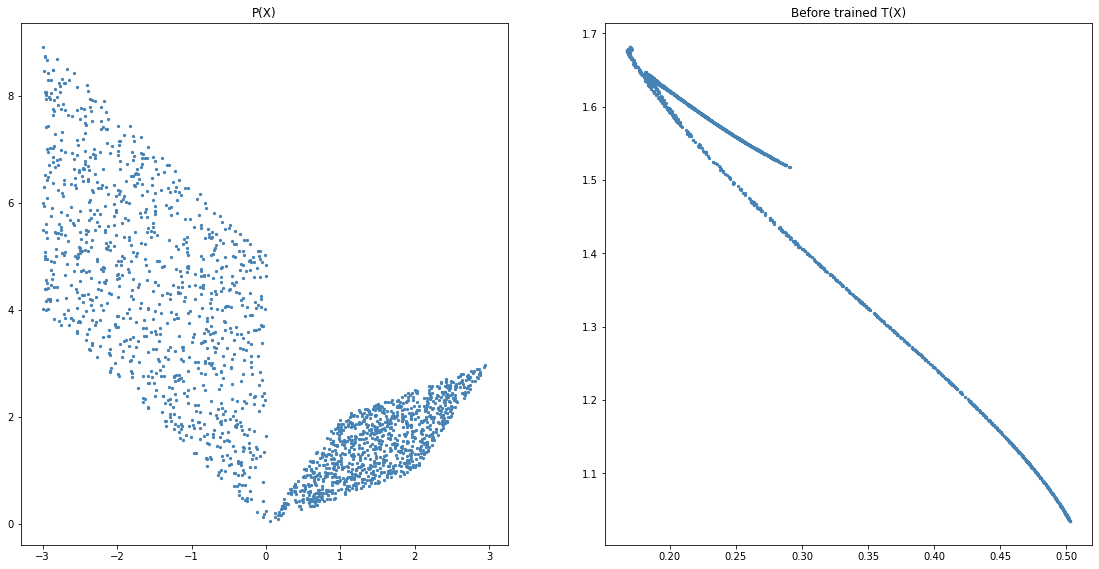

In [ ]:
before_train = next(iter(test_loader))
flows.eval()
z,dz_by_dx = flows(before_train)

compare_graph(test_data,z.detach().numpy(),"P(X)","Before trained T(X)")

Train the flows

In [ ]:
train(flows,10000,train_loader,optimizer,target_distribution)

Iter: 10 Loss: 13.294
Iter: 20 Loss: 11.248
Iter: 30 Loss: 9.586
Iter: 40 Loss: 8.232
Iter: 50 Loss: 7.152
Iter: 60 Loss: 6.333
Iter: 70 Loss: 5.774
Iter: 80 Loss: 5.410
Iter: 90 Loss: 5.140
Iter: 100 Loss: 4.923
Iter: 110 Loss: 4.758
Iter: 120 Loss: 4.644
Iter: 130 Loss: 4.563
Iter: 140 Loss: 4.498
Iter: 150 Loss: 4.434
Iter: 160 Loss: 4.359
Iter: 170 Loss: 4.260
Iter: 180 Loss: 4.144
Iter: 190 Loss: 4.005
Iter: 200 Loss: 3.861
Iter: 210 Loss: 3.714
Iter: 220 Loss: 3.546
Iter: 230 Loss: 3.384
Iter: 240 Loss: 3.272
Iter: 250 Loss: 3.200
Iter: 260 Loss: 3.162
Iter: 270 Loss: 3.143
Iter: 280 Loss: 3.130
Iter: 290 Loss: 3.123
Iter: 300 Loss: 3.117
Iter: 310 Loss: 3.112
Iter: 320 Loss: 3.109
Iter: 330 Loss: 3.104
Iter: 340 Loss: 3.101
Iter: 350 Loss: 3.096
Iter: 360 Loss: 3.091
Iter: 370 Loss: 3.088
Iter: 380 Loss: 3.083
Iter: 390 Loss: 3.080
Iter: 400 Loss: 3.071
Iter: 410 Loss: 3.067
Iter: 420 Loss: 3.061
Iter: 430 Loss: 3.055
Iter: 440 Loss: 3.048
Iter: 450 Loss: 3.040
Iter: 460 Loss: 3

Compare target distribution and after trained $T(X)$

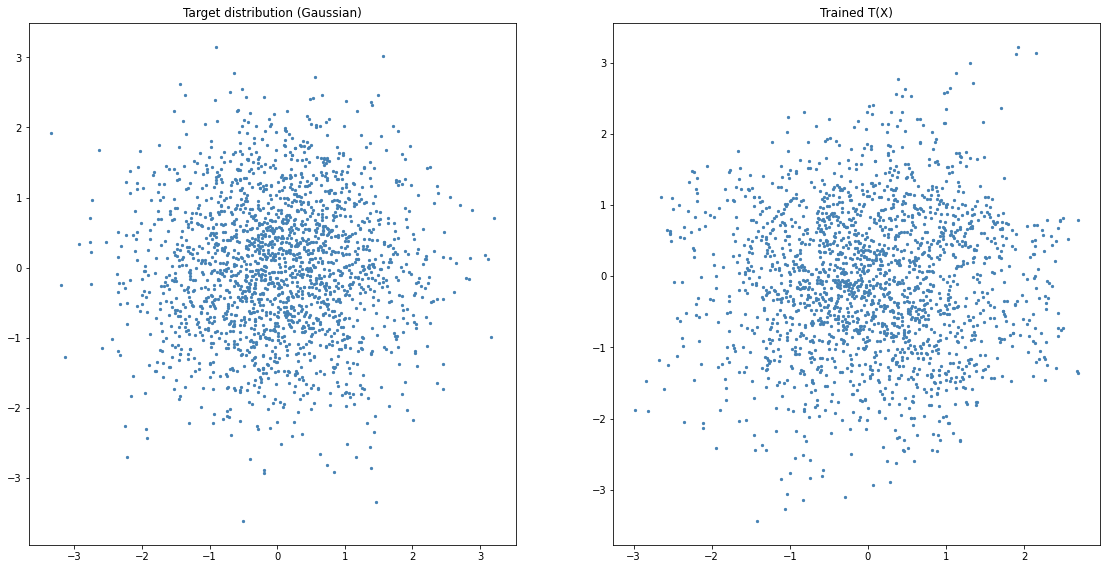

In [ ]:
after_train = next(iter(test_loader))
flows.eval()
z,dz_by_dx = flows(after_train)

compare_graph(target_distribution.sample([2000]).detach().numpy(),z.detach().numpy(),"Target distribution (Gaussian)","Trained T(X)")

Compare $P(X)$ and after trained $T(X)$

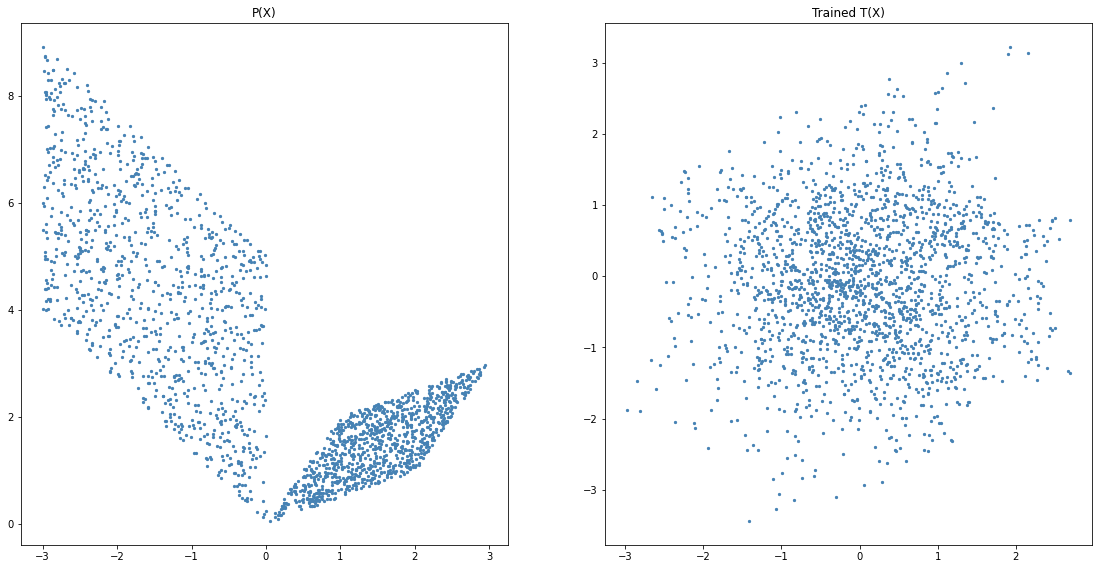

In [ ]:
compare_graph(test_data,z.detach().numpy(),"P(X)","Trained T(X)")

Draw a graph of the dancing inverse state

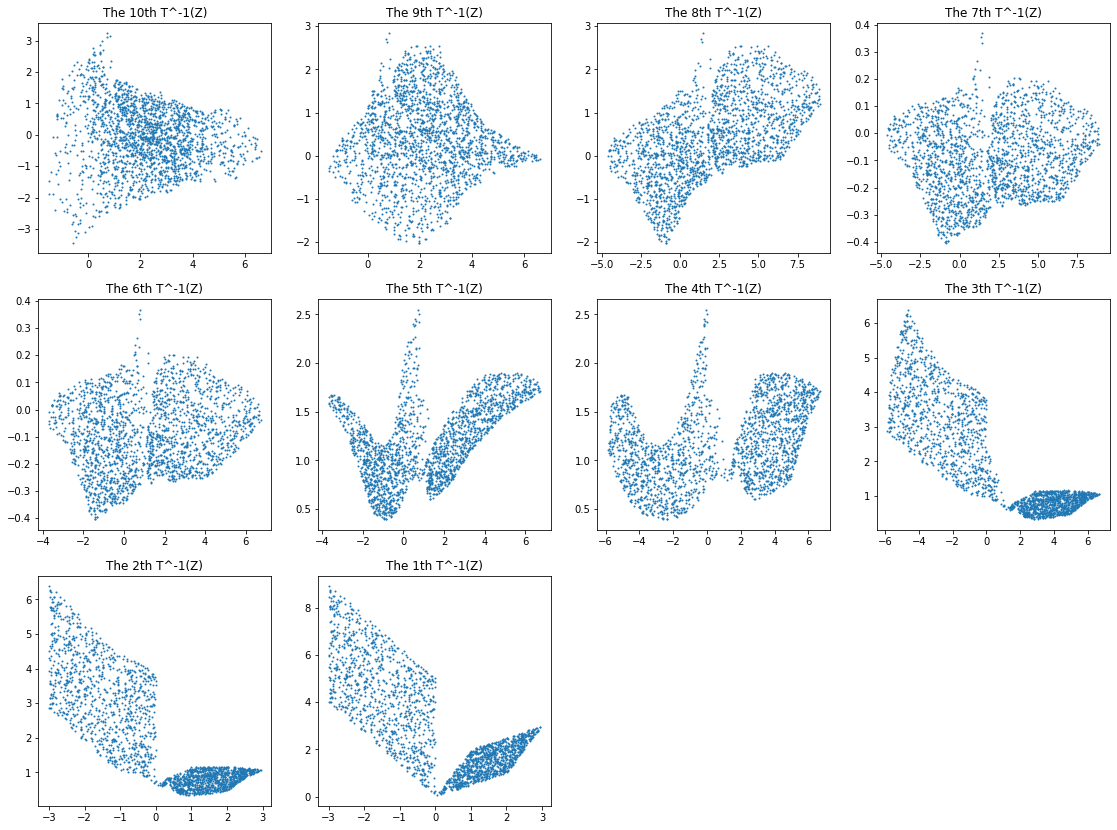

In [ ]:
fig = plt.figure(figsize = (4*4.8,3*4.8))

for f in range(len(flows_list)):
    ax = plt.subplot(3,4,f+1)
    plt.title("The {}th T^-1(Z)".format(len(flows_list) - f))

    z = flows_list[len(flows_list) - f - 1].inverse(z)
    z_ = z.detach().numpy()
    x, y = z_.T[0], z_.T[1]
    ax = plt.scatter(x,y,s=1)

In [ ]:
dist1_loader = data.DataLoader(Dataset(dist1),batch_size=1000,shuffle=True)
dist2_loader = data.DataLoader(Dataset(dist2),batch_size=1000,shuffle=True)

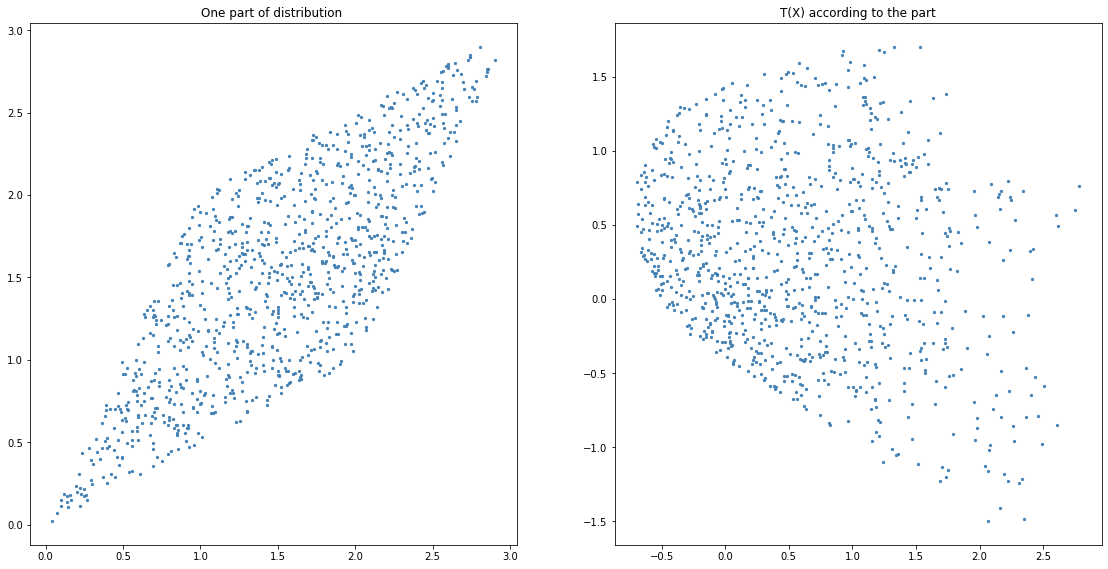

In [ ]:
dist1 = next(iter(dist1_loader))
flows.eval()
z,dz_by_dx = flows(dist1)

compare_graph(dist1,z.detach().numpy(),"One part of distribution ","T(X) according to the part")

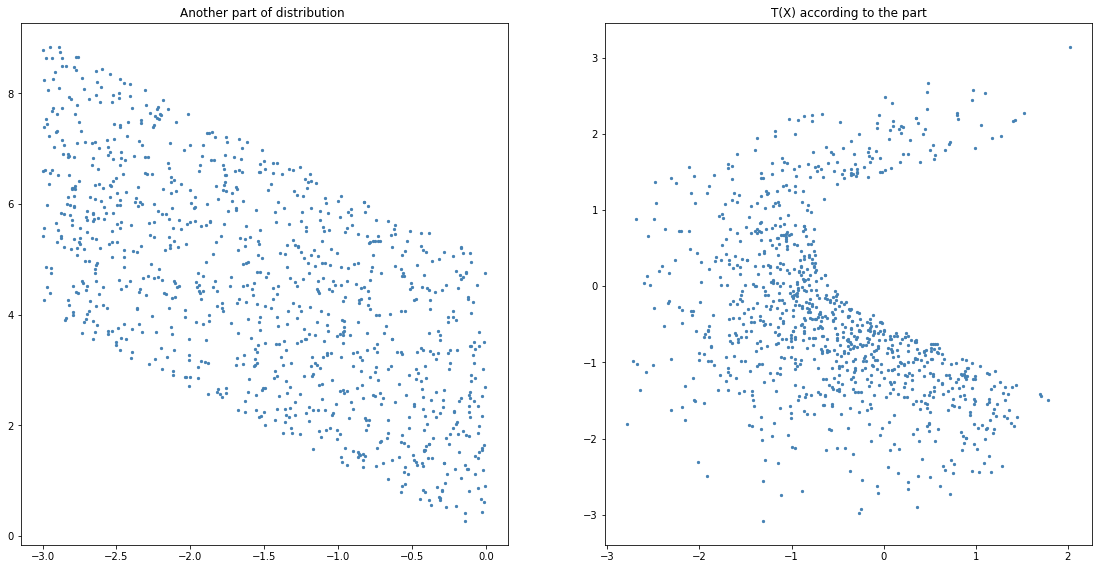

In [ ]:
dist2 = next(iter(dist2_loader))
flows.eval()
z,dz_by_dx = flows(dist2)

compare_graph(dist2,z.detach().numpy(),"Another part of distribution ","T(X) according to the part")

____

<font size=6>Normalising flow with NLL 3-D</font>

Generate P(x) data

In [8]:
x = np.random.uniform(-3.,3.,2048)
y = np.random.uniform(-3.,3.,2048)
z = -(x**2 + y**2) - np.random.uniform(0.,5.,2048)

original_dist = np.vstack((x,y,z)).T

Define a Dataset class

In [9]:
class Dataset(data.Dataset):

    def __init__(self,array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)

    def __getitem__(self,index):
        return self.array[index]

Define the model by applying Real NVP method

In [58]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_size, hidden_size, dtype=torch.double)]
        for _ in range(num_hidden_layers - 1):
            layers.append( nn.Linear(hidden_size, hidden_size, dtype=torch.double) )
            layers.append( nn.ReLU() )
        layers.append( nn.Linear(hidden_size, output_size, dtype=torch.double) )
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class flow_3d(nn.Module):
    def __init__(self, pos, hidden_size=128, num_hidden_layers=4):
        super(flow_3d, self).__init__()
        self.mlp = MLP(3, hidden_size, num_hidden_layers, 3)
        if pos == 1: 
            self.mask = torch.tensor([1,1,0],dtype=torch.double)
        elif pos == 2:
            self.mask = torch.tensor([1,0,1],dtype=torch.double)
        else:
            self.mask = torch.tensor([0,1,1],dtype=torch.double)
        self.mask = self.mask.view(1,-1)
        self.scale_weight1 = nn.Parameter(torch.zeros(1,dtype=torch.double), requires_grad=True)
        self.scale_weight2 = nn.Parameter(torch.zeros(1,dtype=torch.double), requires_grad=True)
        self.bias_weight = nn.Parameter(torch.zeros(1,dtype=torch.double), requires_grad=True)

    def forward(self, x, reverse=False):
        x_masked = x * self.mask
        log_scale1, log_scale2, bias = self.mlp(x_masked).chunk(3,dim=1)
        log_scale = log_scale1.tanh() * self.scale_weight1 + log_scale2.tanh() * self.scale_weight2 + self.bias_weight
        bias = bias  * (1-self.mask)
        log_scale = log_scale * (1-self.mask)
        if reverse:
            x = (x - bias) * torch.exp(-log_scale)
        else:
            x = x * torch.exp(log_scale) + bias
        return x, log_scale

Define a model to compose flows and pass results

In [59]:
class compose_flow(nn.Module):
    def __init__(self, flow_list):
        super(compose_flow, self).__init__()
        self.flow_list = nn.ModuleList(flow_list)

    def forward(self, x):
        z, log_det_jacobian = x, torch.zeros_like(x)
        for flow in self.flow_list:
            z, log_scale = flow(z)
            log_det_jacobian += log_scale
        return z, log_det_jacobian

    def inverse(self, z):
        list = []
        for flow in self.flow_list[::-1]:
            z, _ = flow(z, reverse=True)
            list.append(z)
        return list

Define loss funtion by negative log-likelihood

In [38]:
def loss_fn(target_distribution,z,sum_log_dz_by_dx):
    log_likelihood = target_distribution.log_prob(z).view(-1,1) + sum_log_dz_by_dx
    return -log_likelihood.mean()

Define the train funtion

In [39]:
def train(model,epoch,train_loader,test_loader,target_distribution,lr=0.001):
    optimizer = optim.AdamW(flows.parameters(),lr=lr)
    model.train()
    history = np.zeros((2,epoch))
    for i in range(epoch):
        epoch_loss = []
        for x in train_loader:
            z, sum_log_dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z,sum_log_dz_by_dx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss)

        with torch.no_grad():
            train_loss = np.mean(epoch_loss)
            test_loss = validation(model,test_loader,loss_fn,target_distribution)
            if (i + 1) % 100 == 0:
                print(f"Iter: {i+1} Train Loss: {train_loss: .3f} Test Loss: {test_loss: .3f}")
        history[:,i] = (train_loss,test_loss)

    torch.save({"stats": history}, '/Users/Siyuan/Documents/Learning/GitZone/MSc Project/3D Loss History')

In [40]:
train_loader = data.DataLoader(Dataset(original_dist),batch_size=512,shuffle=True)
test_loader = data.DataLoader(Dataset(original_dist),batch_size=2048,shuffle=True)

In [41]:
target_distribution = torch.distributions.MultivariateNormal(torch.zeros(3), torch.eye(3))

In [60]:
flows_list = [flow_3d(1), flow_3d(2),flow_3d(3), flow_3d(1), flow_3d(2), flow_3d(3)]
flows = compose_flow(flows_list)

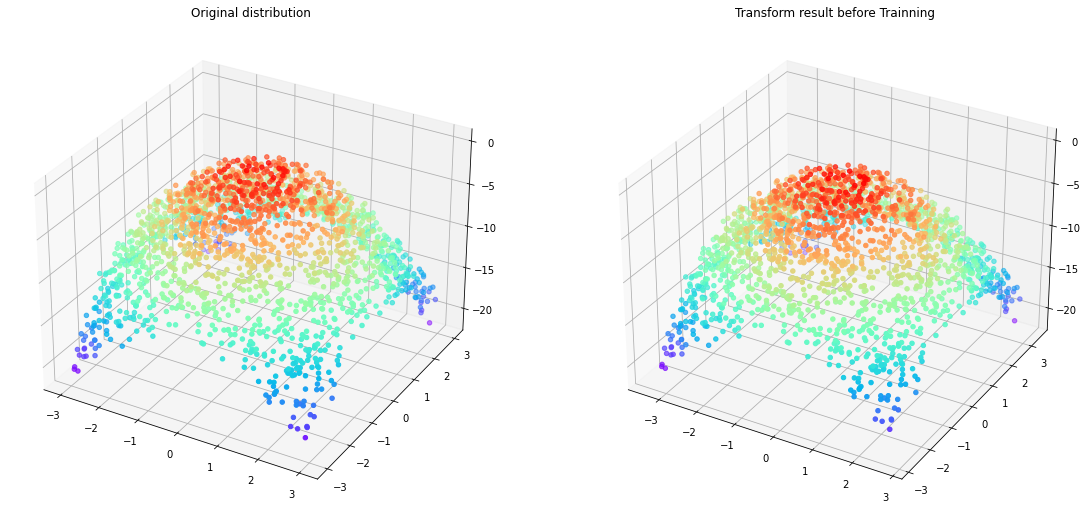

In [61]:
flows.eval()
X = next(iter(test_loader))
z,d = flows(X)

compare_3D_graph(original_dist,z.detach().numpy(),"Original distribution","Transform result before Trainning")

In [62]:
train(flows,2000,train_loader,test_loader,target_distribution,lr=0.001)

Iter: 100 Train Loss:  4.279 Test Loss:  4.277
Iter: 200 Train Loss:  4.235 Test Loss:  4.235
Iter: 300 Train Loss:  4.213 Test Loss:  4.209
Iter: 400 Train Loss:  4.185 Test Loss:  4.177
Iter: 500 Train Loss:  4.158 Test Loss:  4.162
Iter: 600 Train Loss:  4.143 Test Loss:  4.141
Iter: 700 Train Loss:  4.138 Test Loss:  4.136
Iter: 800 Train Loss:  4.114 Test Loss:  4.110
Iter: 900 Train Loss:  4.099 Test Loss:  4.097
Iter: 1000 Train Loss:  4.159 Test Loss:  4.140
Iter: 1100 Train Loss:  4.100 Test Loss:  4.089
Iter: 1200 Train Loss:  4.105 Test Loss:  4.206
Iter: 1300 Train Loss:  4.121 Test Loss:  4.089
Iter: 1400 Train Loss:  4.060 Test Loss:  4.041
Iter: 1500 Train Loss:  4.068 Test Loss:  4.042
Iter: 1600 Train Loss:  4.041 Test Loss:  4.032
Iter: 1700 Train Loss:  4.065 Test Loss:  4.066
Iter: 1800 Train Loss:  4.073 Test Loss:  4.066
Iter: 1900 Train Loss:  4.040 Test Loss:  4.066
Iter: 2000 Train Loss:  4.039 Test Loss:  4.026


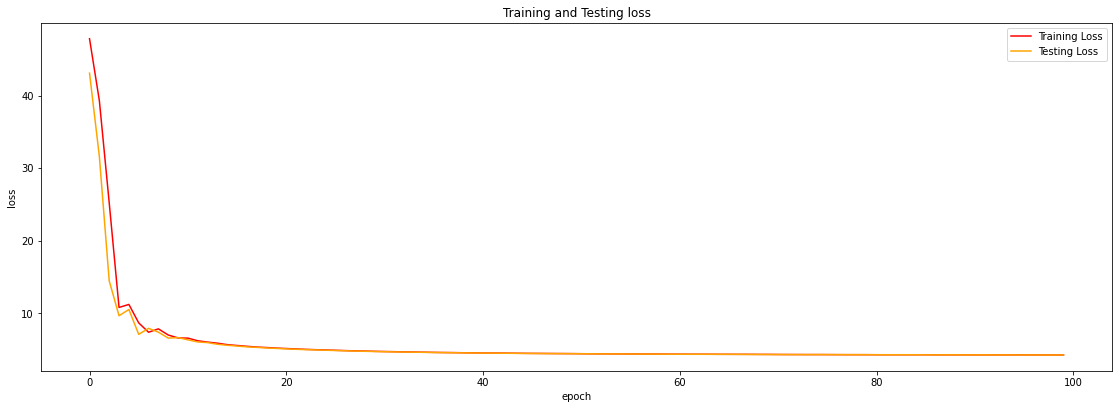

In [63]:
loss_graph('/Users/Siyuan/Documents/Learning/GitZone/MSc Project/3D Loss History',100)

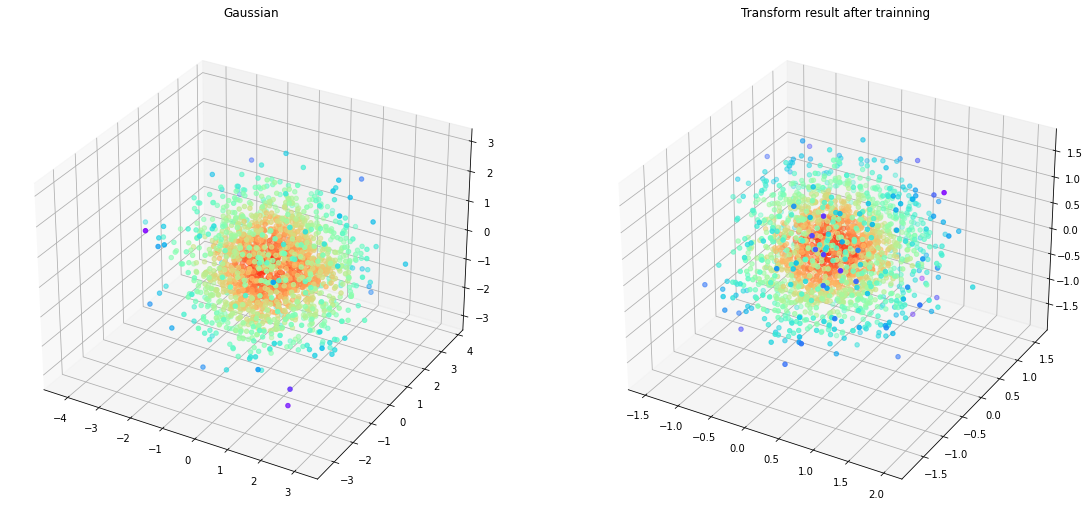

In [64]:
flows.eval()
X = next(iter(test_loader))
z,d = flows(X)

compare_3D_graph(target_distribution.sample([2048]).detach().numpy(),z.detach().numpy(),"Gaussian","Transform result after trainning")

Text(0.5, 0.92, 'Comparision of two distributions')

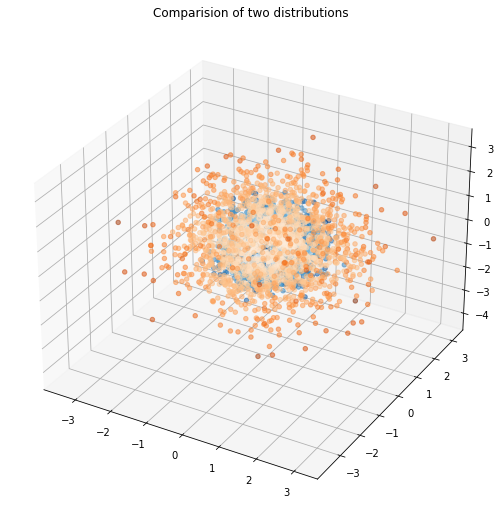

In [65]:
g,t = target_distribution.sample([2048]).detach().numpy(),z.detach().numpy()

fig = plt.figure(figsize=(2 * 9.6, 2 * 9.6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(t.T[0], t.T[1], t.T[2], c = np.abs(t.T[0]) + np.abs(t.T[1]) + np.abs(t.T[2]), cmap =plt.get_cmap('Blues'),alpha=0.5)
ax.scatter3D(g.T[0], g.T[1], g.T[2], c = np.abs(g.T[0]) + np.abs(g.T[1]) + np.abs(g.T[2]), cmap =plt.get_cmap('Oranges'),alpha=0.5)
plt.title("Comparision of two distributions")

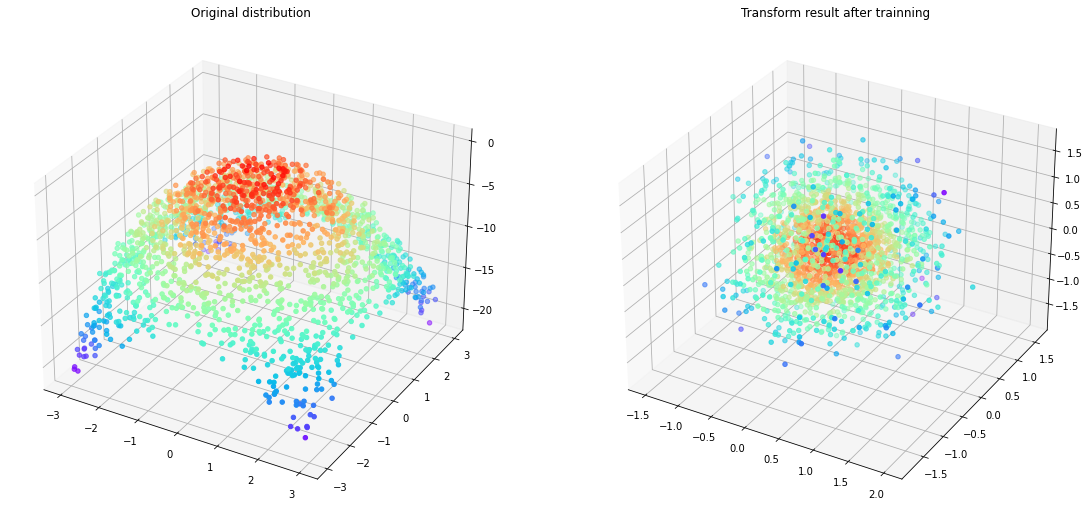

In [66]:
compare_3D_graph(original_dist,z.detach().numpy(),"Original distribution","Transform result after trainning")

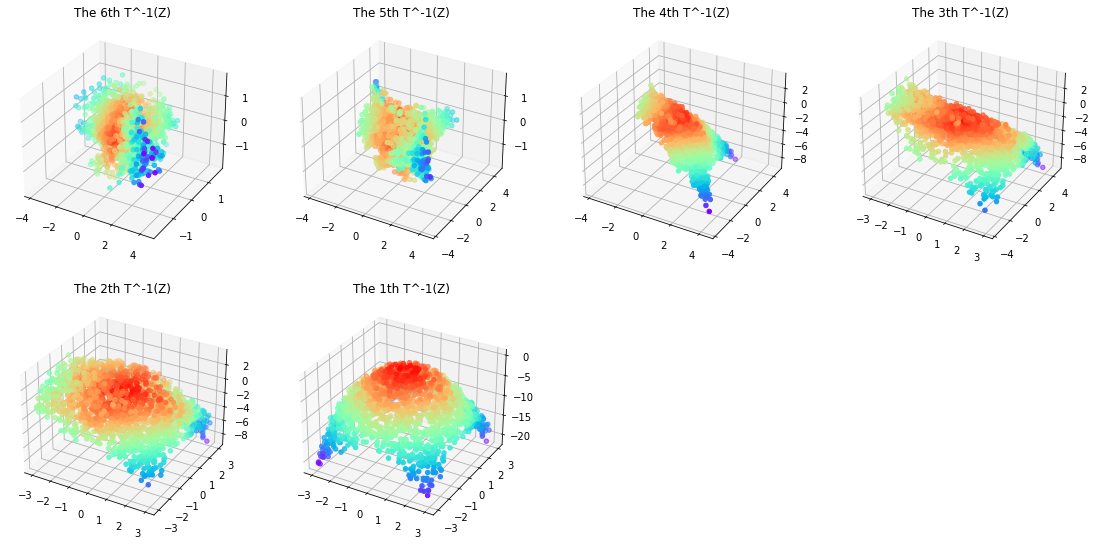

In [67]:
ls = flows.inverse(z)
fig = plt.figure(figsize = (4*4.8,3*4.8))

for f in range(len(ls)):
    ax = fig.add_subplot(3, 4, f+1, projection='3d')
    plt.title("The {}th T^-1(Z)".format(len(ls) - f))

    z_ = ls[f].detach().numpy()
    ax.scatter3D(z_.T[0], z_.T[1], z_.T[2], c = np.abs(z_.T[0]) + np.abs(z_.T[1]) + np.abs(z_.T[2]), cmap =plt.get_cmap('rainbow_r'))

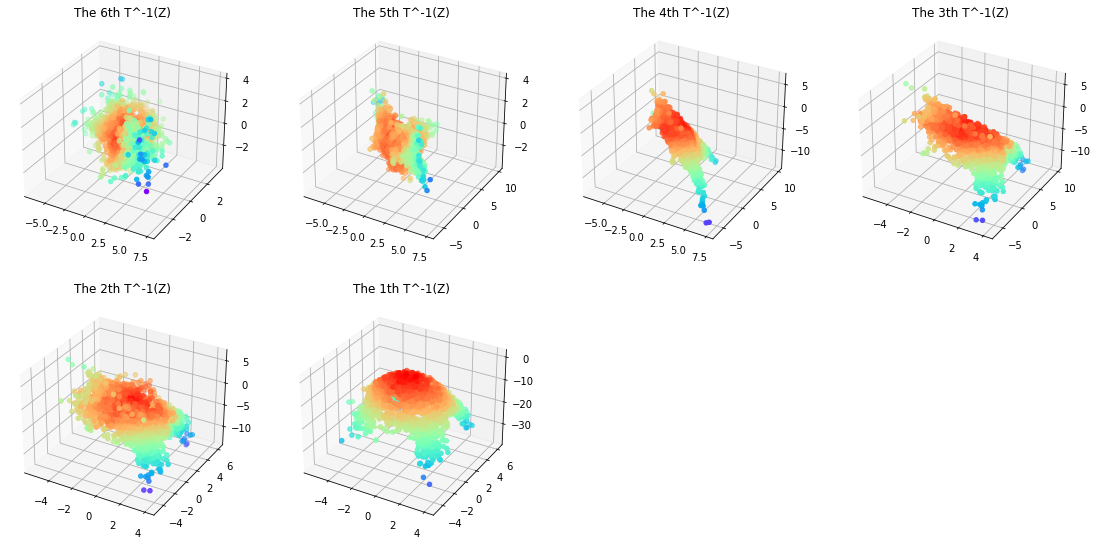

In [68]:
g = target_distribution.sample([2048])
ls = flows.inverse(g)
fig = plt.figure(figsize = (4*4.8,3*4.8))

for f in range(len(ls)):
    ax = fig.add_subplot(3, 4, f+1, projection='3d')
    plt.title("The {}th T^-1(Z)".format(len(ls) - f))

    z_ = ls[f].detach().numpy()
    ax.scatter3D(z_.T[0], z_.T[1], z_.T[2], c = np.abs(z_.T[0]) + np.abs(z_.T[1]) + np.abs(z_.T[2]), cmap =plt.get_cmap('rainbow_r'))

____

<font size=6>Normalising flow on image</font>

In [ ]:
class Dataset(data.Dataset):

    def __init__(self,array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)

    def __getitem__(self,index):
        return self.array[index]

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_size, hidden_size)]
        for _ in range(num_hidden_layers - 1):
            layers.append( nn.Linear(hidden_size, hidden_size) )
            layers.append( nn.ReLU() )
        layers.append( nn.Linear(hidden_size, output_size) )
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class flow_image(nn.Module):

    def __init__(self,flows_number=1):
        super(flow_image,self).__init__()
        self.mlp = MLP(3, 128, 4, 3)
        self.flows_number = flows_number
        self.scale_weight = nn.Parameter(torch.zeros((3,1)), requires_grad=True)
        self.bias_weight = nn.Parameter(torch.zeros((3,1)), requires_grad=True)

    def forward(self,X):
        if self.flows_number % 2 == 1:
            x = torch.chunk(X,2,dim=1)[0]
            y = torch.chunk(X,2,dim=1)[1]
        else:
            y = torch.chunk(X,2,dim=1)[0]
            x = torch.chunk(X,2,dim=1)[1]

        base = torch.concat([x,x**2,x**3],dim=0).T
        self.s = (self.mlp(base).sigmoid() @ self.scale_weight).T
        self.b = (self.mlp(base) @ self.bias_weight).T

        y_new = self.s.exp() * y + self.b
        
        if self.flows_number % 2 == 1:
            z = torch.concat([x,y_new],dim=1)
        else:
            z = torch.concat([y_new,x],dim=1)

        s = torch.concat([torch.ones(1,392),self.s],dim=1)

        return z, s

    def inverse(self,Z):
        if self.flows_number % 2 == 1:
            x = torch.chunk(Z,2,dim=1)[0]
            y = torch.chunk(Z,2,dim=1)[1]
        else:
            y = torch.chunk(Z,2,dim=1)[0]
            x = torch.chunk(Z,2,dim=1)[1]

        y_old = (y - self.b) / self.s.exp()

        if self.flows_number % 2 == 1:
            z = torch.concat([x,y_old],dim=1)
        else:
            z = torch.concat([y_old,x],dim=1)
        
        return z

In [ ]:
class composed_flows(nn.Module):
    
    def __init__(self,models_list):
        super(composed_flows,self).__init__()
        self.models_list = nn.ModuleList(models_list)

    def forward(self,X):
        z, sum_log_dz_by_dx = X, 0
        for flow in self.models_list:
            z, log_dz_by_dx = flow(z)
            sum_log_dz_by_dx += log_dz_by_dx
        
        return z, sum_log_dz_by_dx

In [ ]:
def loss_fn(target_distribution,z,sum_log_dz_by_dx):
    log_likelihood = target_distribution.log_prob(z) + sum_log_dz_by_dx
    return -log_likelihood.mean()

In [ ]:
def train(model,epoch,train_loader,target_distribution,lr=0.001):
    optimizer = optim.Adam(flows.parameters(),lr=lr)
    model.train()
    for i in range(epoch):
        epoch_loss = []
        for x in train_loader:
            z, sum_log_dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z.T,sum_log_dz_by_dx.T)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss)

        with torch.no_grad():
            if i == 0:
                print("Iter: {} Loss: {:.3f}".format(i+1,np.mean(epoch_loss)))
            elif (i + 1) % 10 == 0:
                print("Iter: {} Loss: {:.3f}".format(i+1,np.mean(epoch_loss)))

In [ ]:
mnist = torchvision.datasets.MNIST(root="/Users/Siyuan/Documents/Learning/Msc Project/Data/mnist", train=True,transform=torchvision.transforms.ToTensor(), download=True)
img = mnist[0][0]

noise = target_distribution.sample([784]).T * 0.1
train_data = torch.flatten(img,start_dim=1) + noise
test_data = torch.flatten(img,start_dim=1) + noise

train_loader = data.DataLoader(Dataset(train_data),batch_size=1)
test_loader = data.DataLoader(Dataset(test_data),batch_size=1)

target_distribution = torch.distributions.Normal(torch.tensor([0.]),torch.tensor([1.]))

In [ ]:
flows_list = [flow_image(1),flow_image(2),flow_image(1),flow_image(2),flow_image(1),flow_image(2),flow_image(1),flow_image(2),flow_image(1),flow_image(2)]
flows = composed_flows(flows_list)

In [ ]:
train(flows,700,train_loader,target_distribution,lr=0.001)

Iter: 1 Loss: -4.016
Iter: 10 Loss: -4.086
Iter: 20 Loss: -4.225
Iter: 30 Loss: -4.404
Iter: 40 Loss: -4.526
Iter: 50 Loss: -4.653
Iter: 60 Loss: -4.745
Iter: 70 Loss: -4.828
Iter: 80 Loss: -4.785
Iter: 90 Loss: -4.891
Iter: 100 Loss: -4.946
Iter: 110 Loss: -4.983
Iter: 120 Loss: -5.008
Iter: 130 Loss: -5.040
Iter: 140 Loss: -5.073
Iter: 150 Loss: -5.106
Iter: 160 Loss: -5.119
Iter: 170 Loss: -5.141
Iter: 180 Loss: -5.167
Iter: 190 Loss: -5.212
Iter: 200 Loss: -5.092
Iter: 210 Loss: -5.037
Iter: 220 Loss: -5.123
Iter: 230 Loss: -5.179
Iter: 240 Loss: -5.199
Iter: 250 Loss: -5.226
Iter: 260 Loss: -5.240
Iter: 270 Loss: -5.256
Iter: 280 Loss: -5.265
Iter: 290 Loss: -5.273
Iter: 300 Loss: -5.276
Iter: 310 Loss: -5.273
Iter: 320 Loss: -5.230
Iter: 330 Loss: -5.217
Iter: 340 Loss: -5.265
Iter: 350 Loss: -5.280
Iter: 360 Loss: -5.289
Iter: 370 Loss: -5.292
Iter: 380 Loss: -5.304
Iter: 390 Loss: -5.310
Iter: 400 Loss: -5.316
Iter: 410 Loss: -5.310
Iter: 420 Loss: -5.312
Iter: 430 Loss: -5.315

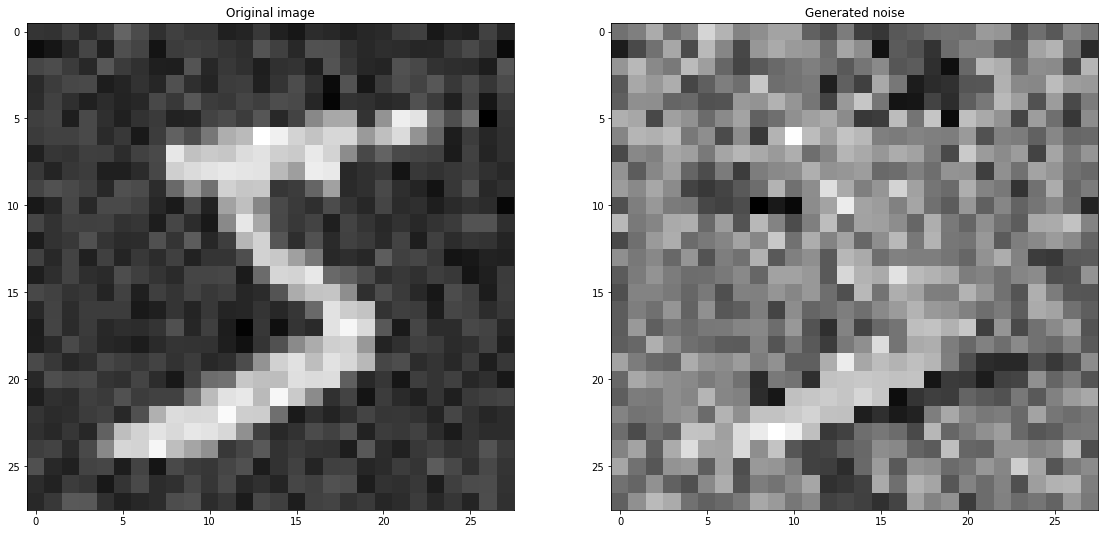

In [ ]:
img = torch.nn.Unflatten(1,(28,28))(next(iter(train_loader)))
flows.eval()
z = flows(next(iter(train_loader)))[0]
result = torch.nn.Unflatten(1,(28,28))(flows(next(iter(train_loader)))[0])

compare_image(img,result,"Original image","Generated noise")

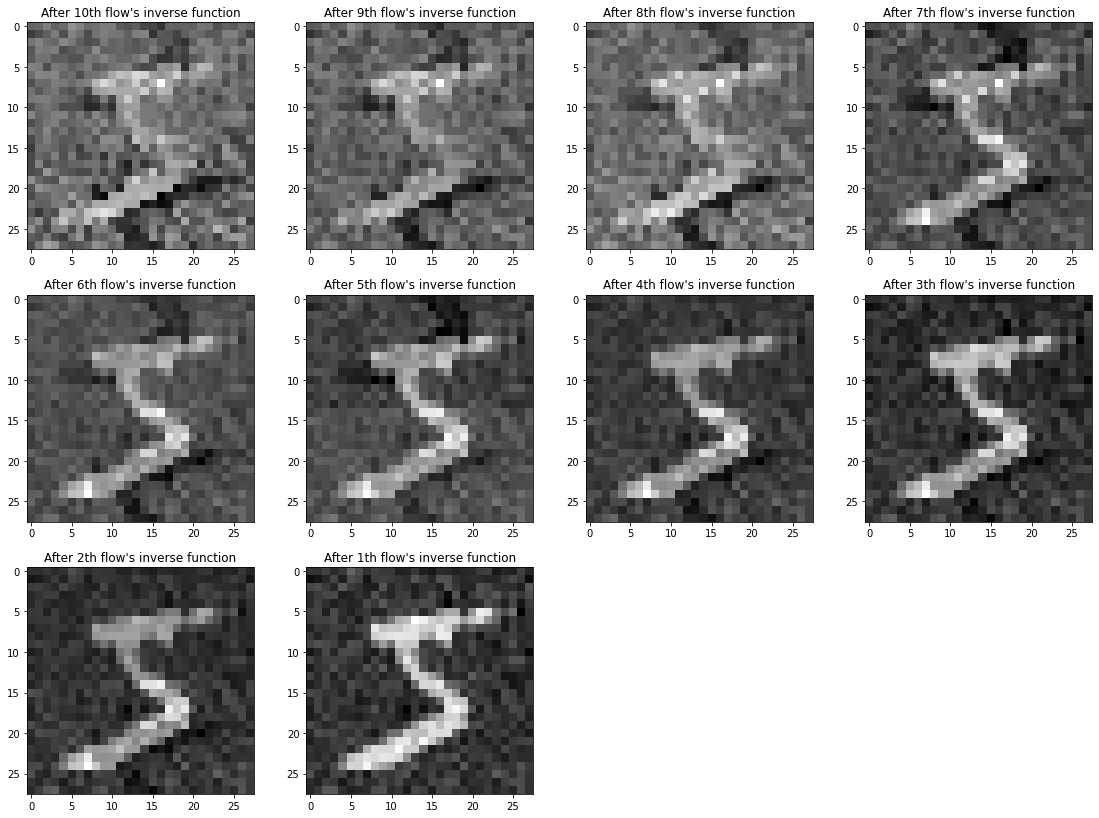

In [ ]:
fig = plt.figure(figsize = (4*4.8,4*4.8))
for f in range(len(flows_list)):
    ax = plt.subplot(4,4,f+1)
    plt.title("After {}th flow's inverse function".format(len(flows_list) - f))

    z = flows_list[len(flows_list) - f - 1].inverse(z)
    z_ = torch.nn.Unflatten(1,(28,28))(z)
    plt.imshow(np.transpose(z_.detach().numpy(),(1,2,0)),cmap = 'gray')

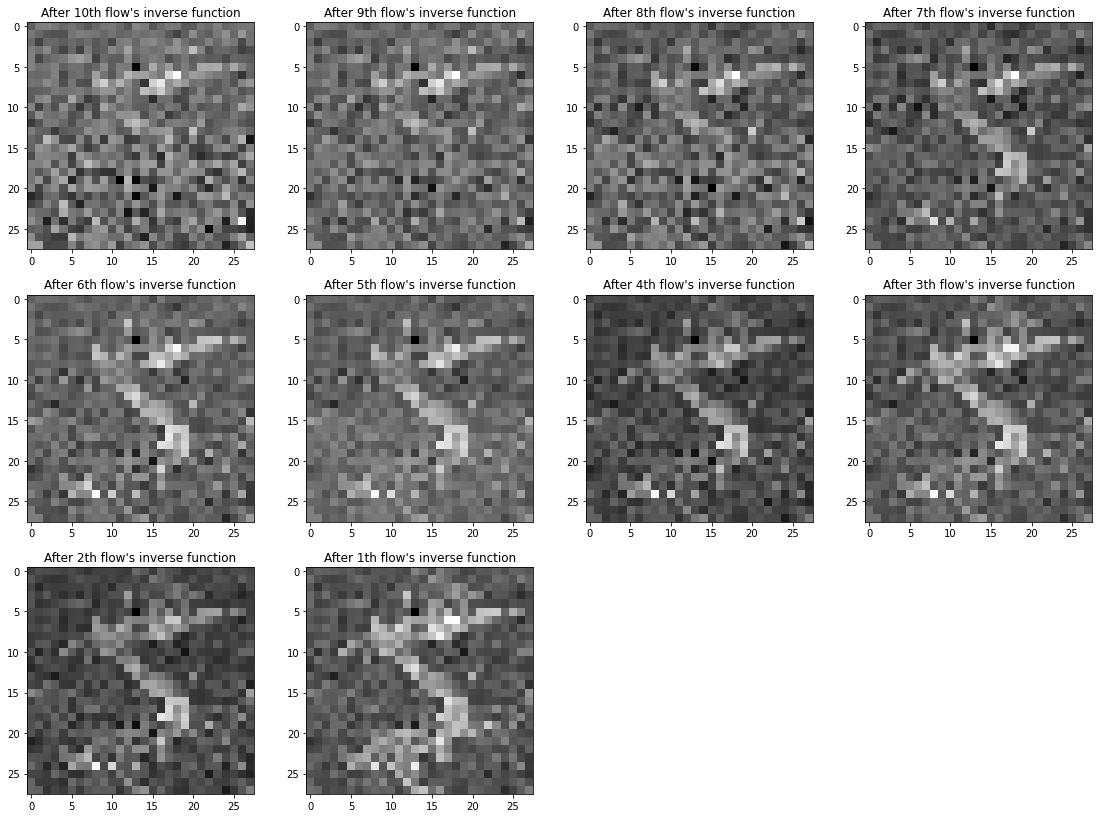

In [ ]:
g = target_distribution.sample([784]).T
fig = plt.figure(figsize = (4*4.8,4*4.8))
for f in range(len(flows_list)):
    ax = plt.subplot(4,4,f+1)
    plt.title("After {}th flow's inverse function".format(len(flows_list) - f))

    g = flows_list[len(flows_list) - f - 1].inverse(g)
    z_ = torch.nn.Unflatten(1,(28,28))(g)
    plt.imshow(np.transpose(z_.detach().numpy(),(1,2,0)),cmap = 'gray')

____

<font size=6>Normalising flow on image</font>

In [547]:
class Dataset(data.Dataset):

    def __init__(self,array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)

    def __getitem__(self,index):
        return self.array[index]

In [548]:
class Preprocess(nn.Module):
    def __init__(self):
        super(Preprocess, self).__init__()

    def forward(self, x, reverse=False):
        if reverse:
            return (x.sigmoid() - 0.05) / 0.9
        x += dist.Uniform(0.0, 1.0).sample(x.size())
        x = 0.05 + 0.9 * (x / 4.0)
        z = torch.log(x) - torch.log(1-x)
        log_det_jacobian = -x.log() - (1-x).log() + torch.tensor(0.9/4).log()
        return z, log_det_jacobian


class WeightNormConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)

In [549]:
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, 1, stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, 3, stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, 1, stride=1, padding=0),
        )

    def forward(self, x):
        return x + self.block(x)


class ResNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=6, intermediate_channel=64, num_blocks=4):
        super(ResNet, self).__init__()
        layers = [WeightNormConv2d(in_channel, intermediate_channel, 3, stride=1, padding=1), nn.ReLU()]
        for _ in range(num_blocks):
            layers.append( ResNetBlock(intermediate_channel) )
        layers.append(nn.ReLU())
        layers.append( WeightNormConv2d(intermediate_channel, out_channel, 3, stride=1, padding=1) )

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class AffineCheckerboardTransform(nn.Module):
    def __init__(self, height, width, top_left_zero=False):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = self.create_mask(height, width, top_left_zero)
        self.scale_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = ResNet()

    def create_mask(self, height, width, top_left_zero):
        mask = (torch.arange(height).view(-1,1) + torch.arange(width)) 
        if not top_left_zero:
            mask += 1
        return (mask % 2).unsqueeze(0).unsqueeze(0)

    def forward(self, x, reverse=False):
        self.mask = self.mask
        x_masked = x * self.mask
        log_scale, shift = self.net(x_masked).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale

        log_scale = log_scale * (1 - self.mask)
        shift = shift * (1 - self.mask)
        if reverse:
            x = (x - shift) * torch.exp(-log_scale)
            return x
        else:
            x = x * log_scale.exp() + shift
            return x, log_scale


class AffineChannelwiseTransform(nn.Module):
    def __init__(self, top_half_as_input):
        super(AffineChannelwiseTransform, self).__init__()
        self.top_half_as_input = top_half_as_input
        self.scale_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = ResNet(in_channel=6, out_channel=12)

    def forward(self, x, reverse=False):
        if self.top_half_as_input:
            fixed, not_fixed = x.chunk(2, dim=1)
        else:
            not_fixed, fixed = x.chunk(2, dim=1)
        log_scale, shift = self.net(fixed).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale

        if reverse:
            not_fixed = (not_fixed - shift) * torch.exp(-log_scale)
        else:
            not_fixed = not_fixed * log_scale.exp() + shift
        
        if self.top_half_as_input:
            x_modified = torch.cat([fixed, not_fixed], dim=1)
            log_scale = torch.cat([log_scale, torch.zeros_like(log_scale)], dim=1)
        else:
            x_modified = torch.cat([not_fixed, fixed], dim=1)
            log_scale = torch.cat([torch.zeros_like(log_scale), log_scale], dim=1)
        
        if reverse:
            return x_modified
        return x_modified, log_scale

In [550]:
class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale)
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = -torch.log( torch.std(x, [0,2,3], keepdim=True) )
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

In [551]:
class RealNVP(nn.Module):
    def __init__(self, height, width):
        super(RealNVP, self).__init__()
        self.preprocess = Preprocess()
        self.transforms_checkered_1 = nn.ModuleList([
            AffineCheckerboardTransform(height, width, False),
            ActNorm(3),
            AffineCheckerboardTransform(height, width, True),
            ActNorm(3),
            AffineCheckerboardTransform(height, width, False),
            ActNorm(3),
            AffineCheckerboardTransform(height, width, True)
        ])

        self.transforms_channelwise = nn.ModuleList([
            AffineChannelwiseTransform(True),
            ActNorm(12),
            AffineChannelwiseTransform(False),
            ActNorm(12),
            AffineChannelwiseTransform(True),
        ])

        self.transforms_checkered_2 = nn.ModuleList([
            AffineCheckerboardTransform(height, width, False),
            ActNorm(3),
            AffineCheckerboardTransform(height, width, True),
            ActNorm(3),
            AffineCheckerboardTransform(height, width, False)
        ])

    def squeeze(self, x):
        batch_size, num_channels, height, width = x.size()
        x = x.reshape(batch_size, num_channels, height//2, 2, width//2, 2)
        x = x.permute(0,1,3,5,2,4)
        x = x.reshape(batch_size, num_channels*4, height//2, width//2)
        return x

    def unsqueeze(self, x):
        batch_size, num_channels, height, width = x.size()
        x = x.reshape(batch_size, num_channels//4, 2, 2, height, width)
        x = x.permute(0,1,4,2,5,3)
        x = x.reshape(batch_size, num_channels//4, height*2, width*2)
        return x

    def forward(self, x):
        z, log_det_jacobian_total = x, torch.zeros_like(x)
        
        z, log_det_jacobian = self.preprocess(z)
        log_det_jacobian_total += log_det_jacobian

        for transform in self.transforms_checkered_1:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        z = self.squeeze(z)
        log_det_jacobian_total = self.squeeze(log_det_jacobian_total)

        for transform in self.transforms_channelwise:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        z = self.unsqueeze(z)
        log_det_jacobian_total = self.unsqueeze(log_det_jacobian_total)

        for transform in self.transforms_checkered_2:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        return z, log_det_jacobian_total

    def inverse(self, z):
        x = z
        for transform in self.transforms_checkered_2[::-1]:
            x = transform(x, reverse=True)
        
        x = self.squeeze(x)
        for transform in self.transforms_channelwise[::-1]:
            x = transform(x, reverse=True)

        x = self.unsqueeze(x)
        for transform in self.transforms_checkered_1[::-1]:
            x = transform(x, reverse=True)

        x = self.preprocess(x, reverse=True)

        return x

In [552]:
def loss_fn(target_distribution,z,sum_log_dz_by_dx):
    log_likelihood = target_distribution.log_prob(z) + sum_log_dz_by_dx
    return -log_likelihood.mean()

In [553]:
def train(model,epoch,train_loader,target_distribution,lr=0.001):
    optimizer = optim.Adam(flows.parameters(),lr=lr)
    model.train()
    for i in range(epoch):
        epoch_loss = []
        for x in train_loader:
            z, sum_log_dz_by_dx = model(x)
            loss = loss_fn(target_distribution,z,sum_log_dz_by_dx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss)

        with torch.no_grad():
            if i == 0:
                print("Iter: {} Loss: {:.3f}".format(i+1,np.mean(epoch_loss)))
            elif (i + 1) % 10 == 0:
                print("Iter: {} Loss: {:.3f}".format(i+1,np.mean(epoch_loss)))

In [585]:
cifar = torchvision.datasets.CIFAR10(root="/Users/Siyuan/Documents/Learning/Msc Project/Data/cifar10", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_data = []
train_data.append(cifar[1][0]) 

train_loader = data.DataLoader(Dataset(train_data),batch_size=1)
test_loader = data.DataLoader(Dataset(train_data),batch_size=1)

target_distribution = torch.distributions.Normal(torch.zeros(1), torch.ones(1))

Files already downloaded and verified


In [586]:
flows = RealNVP(32,32)

In [587]:
train(flows,700,train_loader,target_distribution,lr=0.001)

Iter: 1 Loss: 0.593
Iter: 10 Loss: 0.419
Iter: 20 Loss: 0.354
Iter: 30 Loss: 0.323
Iter: 40 Loss: 0.295
Iter: 50 Loss: 0.298
Iter: 60 Loss: 0.289
Iter: 70 Loss: 0.282
Iter: 80 Loss: 0.276
Iter: 90 Loss: 0.267
Iter: 100 Loss: 0.262
Iter: 110 Loss: 0.274
Iter: 120 Loss: 0.263
Iter: 130 Loss: 0.254
Iter: 140 Loss: 0.248
Iter: 150 Loss: 0.262
Iter: 160 Loss: 0.236
Iter: 170 Loss: 0.259
Iter: 180 Loss: 0.249
Iter: 190 Loss: 0.239
Iter: 200 Loss: 0.253
Iter: 210 Loss: 0.243
Iter: 220 Loss: 0.237
Iter: 230 Loss: 0.248
Iter: 240 Loss: 0.249
Iter: 250 Loss: 0.248
Iter: 260 Loss: 0.243
Iter: 270 Loss: 0.244
Iter: 280 Loss: 0.228
Iter: 290 Loss: 0.227
Iter: 300 Loss: 0.245
Iter: 310 Loss: 0.240
Iter: 320 Loss: 0.249
Iter: 330 Loss: 0.251
Iter: 340 Loss: 0.225
Iter: 350 Loss: 0.260
Iter: 360 Loss: 0.236
Iter: 370 Loss: 0.253
Iter: 380 Loss: 0.238
Iter: 390 Loss: 0.242
Iter: 400 Loss: 0.227
Iter: 410 Loss: 0.227
Iter: 420 Loss: 0.241
Iter: 430 Loss: 0.228
Iter: 440 Loss: 0.235
Iter: 450 Loss: 0.230

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


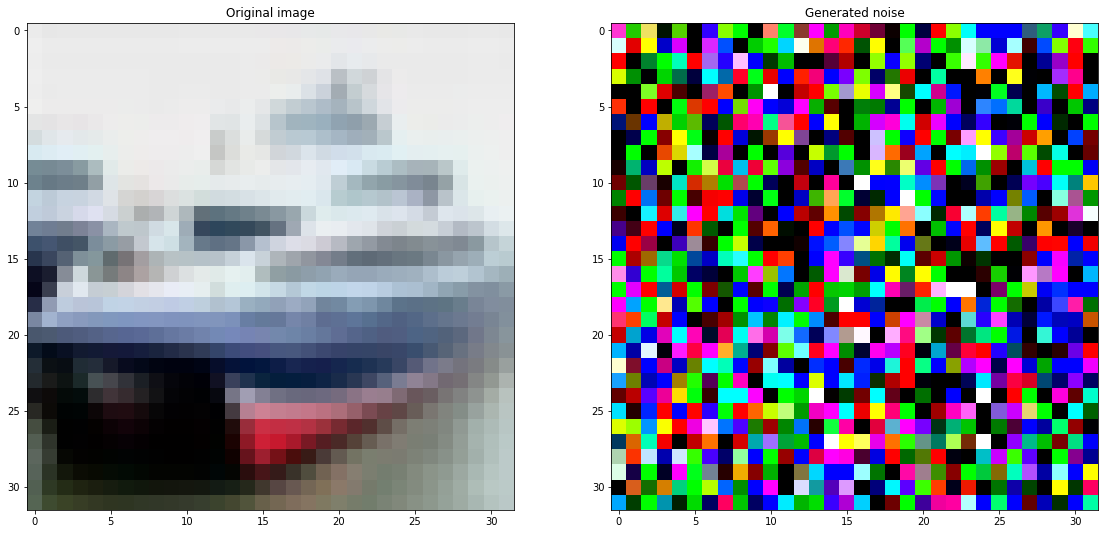

In [588]:
flows.eval()
z,d = flows(next(iter(test_loader)))

compare_image(next(iter(test_loader)).squeeze(0),z.squeeze(0),"Original image","Generated noise")

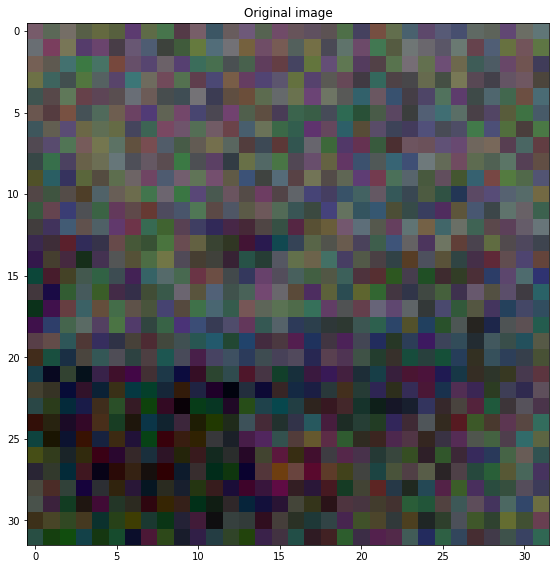

In [589]:
x = flows.inverse(z)
plt.figure(figsize = (1*9.6,1*9.6))
plt.title("After Trained image")
plt.imshow(np.transpose(x.squeeze(0).detach().numpy(),(1,2,0)),cmap = 'gray')

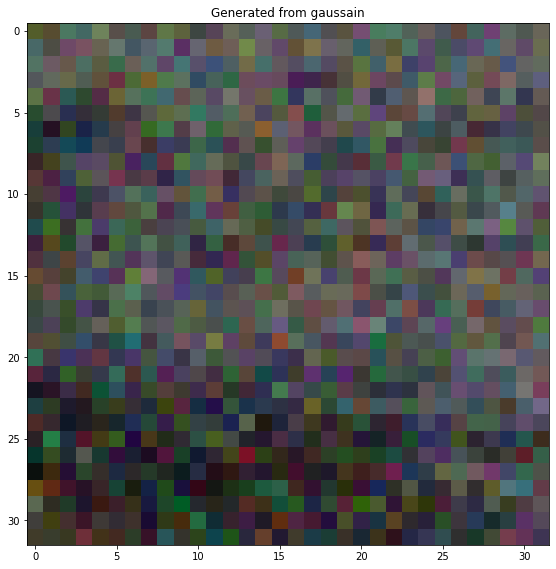

In [590]:
z = torch.distributions.normal.Normal(0.0, 1.0).sample([1,3,32,32])
x = flows.inverse(z)
plt.figure(figsize = (1*9.6,1*9.6))
plt.title("Generated from gaussain")
plt.imshow(np.transpose(x.squeeze(0).detach().numpy(),(1,2,0)),cmap = 'gray')